# Statistical Modeling and Advanced Regression Analyses

R Tutorials

Holger Sennhenn-Reulen [](https://orcid.org/0000-0002-4782-4387) (Northwest German Forest Research Institute (NW-FVA))  
January 22, 2025

# Software

We use the statistical software environment *R* ([R Core Team, 2024](#ref-RCoreTeam2024)), and R add-on packages *ggplot2* ([Wickham, 2016](#ref-Wickham2016)).

This document is produced using *Quarto* ([Allaire et al., 2024](#ref-AllaireEtAl2024)). <!-- Graphics in the PDF version are rendered using R add-on package *tikzDevice* [@SharpsteenBracken2023].  -->

## Organize R Session

In [ ]:
rm(list = ls())
library("ggplot2")

# Linear Regression Model

## Data Simulation

Data are simulated according to the equations given in the lecture slides[1]:

[1] For two covariates `x_1` and `x_2`.

In [ ]:
set.seed(123)
N <- 500
df <- data.frame(x_1 = runif(n = N), 
                 x_2 = runif(n = N))
(beta_0 <- rnorm(n = 1, mean = 1, sd = .1))

[1] 0.9398107

[1] 0.9006301

[1] -0.3973215

[1] 0.293026

### Visualisations

In [ ]:
ggplot(data = df, aes(x = x_1, y = x_2)) + 
  geom_point()

In [ ]:
ggplot(data = df, aes(x = x_1, y = mu, color = x_2)) + 
  geom_point()

In [ ]:
ggplot(data = df, aes(x = x_2, y = mu, color = x_1)) + 
  geom_point()

In [ ]:
ggplot(data = df, aes(x = x_1, y = x_2, color = mu)) + 
  geom_point()

In [ ]:
ggplot(data = df, aes(x = x_1, y = x_2, color = y)) + 
  geom_point()

## Modeling

The basic R command for (frequentist) estimation of the parameters of a linear regression model is a call to the function `lm`:

In [ ]:
m <- lm(y ~ x_1 + x_2, data = df)
summary(m)


Call:
lm(formula = y ~ x_1 + x_2, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.82082 -0.19805  0.00329  0.19051  0.81138 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.91291    0.03448  26.476  < 2e-16 ***
x_1          0.91533    0.04668  19.610  < 2e-16 ***
x_2         -0.36218    0.04566  -7.933 1.43e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2963 on 497 degrees of freedom
Multiple R-squared:  0.4674,    Adjusted R-squared:  0.4652 
F-statistic:   218 on 2 and 497 DF,  p-value: < 2.2e-16

### Visualisations

In [ ]:
nd <- data.frame(x_1 = seq(0, 1, by = .1), 
                 x_2 = .5)
nd$mu <- predict(m, newdata = nd)
ggplot(data = df, aes(x = x_1, y = mu, color = x_2)) + 
  geom_point() + 
  geom_line(data = nd, aes(x = x_1, y = mu, color = x_2))

In [ ]:
nd <- data.frame(expand.grid('x_1' = seq(0, 1, by = .1), 
                             'x_2' = seq(0, 1, by = .1)))
nd$mu <- predict(m, newdata = nd)
ggplot(data = df, aes(x = x_1, y = mu, color = x_2)) + 
  geom_point() + 
  geom_line(data = nd, aes(x = x_1, y = mu, color = x_2, group = x_2))

## Add-Ons

### Add-On Linear Model: A) Stancode

#### Stan Users Guide

*Probabilistic Programming Languages* such as *Stan* ([Carpenter et al., 2017](#ref-CarpenterEtAl2017)) allow to `plug together` the single parts of a statistical regression model[1]:

The following Stan-code is published [here](https://mc-stan.org/docs/stan-users-guide/regression.html) in the [Stan users guide](https://mc-stan.org/docs/stan-users-guide/index.html):

[1] Which is actually pretty ‘readable’ if you get used to the structure for a simple model such the linear regression model.

In [ ]:
cat(readLines("lm.stan"), sep = "\n")

data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
}

#### Stancode generated by calling `brms::brm`

The R add-on package *brms* ([Bürkner, 2017](#ref-Buerkner2017), [2018](#ref-Buerkner2018)) allows to implent advanced regression models without being an expert in ‘Stan-programming’.

Here is the Stan-code that is implemented by ‘brms’ for our linear regression model example:

In [ ]:
brms::make_stancode(brms::bf(y ~ x_1 + x_2, center = F), data = df)

In [ ]:
cat(readLines("lm_brms.stan"), sep = "\n")

// generated with brms 2.21.0
functions {
}
data {
  int<lower=1> N;  // total number of observations
  vector[N] Y;  // response variable
  int<lower=1> K;  // number of population-level effects
  matrix[N, K] X;  // population-level design matrix
  int prior_only;  // should the likelihood be ignored?
}
transformed data {
}
parameters {
  vector[K] b;  // regression coefficients
  real<lower=0> sigma;  // dispersion parameter
}
transformed parameters {
  real lprior = 0;  // prior contributions to the log posterior
  lprior += student_t_lpdf(sigma | 3, 0, 2.5)
    - 1 * student_t_lccdf(0 | 3, 0, 2.5);
}
model {
  // likelihood including constants
  if (!prior_only) {
    target += normal_id_glm_lpdf(Y | X, 0, b, sigma);
  }
  // priors including constants
  target += lprior;
}
generated quantities {
}

### Add-On Linear Model: B) Posterior predictive check: an introduction ‘by hand’

Having an `lm` object already, it is rather straightforward to get posterior samples by using function `sim` from the *arm* ([Gelman & Su, 2024](#ref-GelmanSu2024)) package:

In [ ]:
library("arm")

Lade nötiges Paket: MASS

Lade nötiges Paket: Matrix

Lade nötiges Paket: lme4


arm (Version 1.14-4, built: 2024-4-1)

Working directory is /home/hsennhenn/Dropbox/teaching/Statistical_Modeling_and_Advanced_Regression_Analyses

Formal class 'sim' [package "arm"] with 2 slots
  ..@ coef : num [1:100, 1:3] 0.882 1.014 0.904 0.978 0.958 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:3] "(Intercept)" "x_1" "x_2"
  ..@ sigma: num [1:100] 0.323 0.303 0.292 0.309 0.29 ...

     (Intercept)       x_1        x_2     sigma
[1,]   0.8816414 0.9245094 -0.3362733 0.3227662
[2,]   1.0139849 0.7317948 -0.3398411 0.3033703
[3,]   0.9037042 0.9155575 -0.3506924 0.2922883
[4,]   0.9776909 0.8392790 -0.3845609 0.3090220
[5,]   0.9579213 0.8977625 -0.4284596 0.2900632
[6,]   0.9549211 0.8478278 -0.3937226 0.3094227

Predict the response for the covariate data as provided by the original data-frame `df` - here only by using the first posterior sample:

In [ ]:
s <- 1
S[s, ]

(Intercept)         x_1         x_2       sigma 
  0.8816414   0.9245094  -0.3362733   0.3227662 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Now let’s repeat the same for 9 different posterior samples:

In [ ]:
pp <- NULL
for (s in 1:9) {
  mu_s <- S[s, '(Intercept)'] + S[s, 'x_1'] * df$x_1 + S[s, 'x_2'] * df$x_2
  y_s <- rnorm(n = nrow(df), mean = mu_s, sd = S[s, 'sigma'])
  pp <- rbind(pp, 
              data.frame(y = df$y, source = "original", s = s), 
              data.frame(y = y_s, source = "predicted", s = s))
}
ggplot(data = pp, aes(x = y, fill = source)) + 
  geom_histogram(alpha = .5, position = "identity") + 
  facet_wrap(~ s)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

In [ ]:
ggplot(data = pp, aes(x = y, fill = source)) + 
  geom_density(alpha = .5, position = "identity") + 
  facet_wrap(~ s)

In [ ]:
ggplot(data = pp, aes(x = y, colour = source)) + 
  stat_ecdf() + 
  facet_wrap(~ s)

In [ ]:
ggplot(data = subset(pp, source == "predicted"),
       aes(x = y, group = s)) + 
  geom_density(position = "identity", fill = NA, colour = "grey") +
  geom_density(data = subset(pp, source == "original" & s == 1), 
               aes(x = y), linewidth = 1)

# Binary Regression Model

In [ ]:
rm(list = ls())
library("ggplot2")
library("plyr")

## Data Simulation

Data are simulated similarly as for the linear model:

In [ ]:
set.seed(123)
N <- 500
df <- data.frame(x_1 = runif(n = N), 
                 x_2 = runif(n = N))
(beta_0 <- rnorm(n = 1, mean = 0, sd = .1))

[1] -0.06018928

[1] 0.9006301

[1] -0.3973215

### Visualisations

In [ ]:
df$x_1_c <- cut(df$x_1, breaks = seq(0, 1, by = .1), 
                include.lowest = T, 
                labels = seq(.05, .95, by = .1))
df$x_1_c <- as.numeric(as.character(df$x_1_c))
df_p_A <- ddply(df, c("x_1_c"), summarise, 
                p = mean(y > .5))
df_p_A <- data.frame('p' = rep(df_p_A$p, each = 2), 
                     'x_1' = sort(c(df_p_A$x_1_c - .05, 
                                    df_p_A$x_1_c + .05)))
df_p_B <- data.frame('x_1' = seq(0, 1, by = .01), 
                     'p' = plogis(beta_0 + 
                                    beta_x_1 * seq(0, 1, by = .01) + 
                                    beta_x_2 * .5))
set.seed(0)
ggplot(data = df, aes(x = x_1, y = y)) + 
  geom_jitter(aes(color = x_2), width = 0, height = .1) +
  geom_line(data = df_p_A, aes(y = p, group = p)) +
  geom_line(data = df_p_B, aes(y = p), linetype = 2)
## ... 'not as linear as it seems':
# plot(df_p_B$x_1[-1], diff(df_p_B$p))

## Modeling

The basic R command for (frequentist) estimation of the parameters of a binary regression model is a call to the function `glm` with `family` argument `binomial`:

In [ ]:
m <- glm(y ~ x_1 + x_2, data = df, 
         family = binomial(link = 'logit'))
summary(m)


Call:
glm(formula = y ~ x_1 + x_2, family = binomial(link = "logit"), 
    data = df)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.2908     0.2358  -1.233 0.217531    
x_1           1.1598     0.3248   3.570 0.000356 ***
x_2          -0.1713     0.3138  -0.546 0.585034    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 688.53  on 499  degrees of freedom
Residual deviance: 675.30  on 497  degrees of freedom
AIC: 681.3

Number of Fisher Scoring iterations: 4

### Visualisations

In [ ]:
nd <- data.frame('x_1' = 0:1, 'x_2' = .5)
(nd$eta <- predict(m, newdata = nd, type = 'link'))

         1          2 
-0.3764387  0.7833343 

[1] -0.3764387  0.7833343

        1         2 
0.2891090 0.1177866 

[1] 0.2891090 0.1177866

In [ ]:
nd <- data.frame(x_1 = seq(0, 1, by = .1), 
                 x_2 = .5)
(nd$p <- predict(m, newdata = nd, type = 'response'))

 [1] 0.4069861 0.4352503 0.4639417 0.4928738 0.5218537 0.5506872 0.5791841
 [8] 0.6071630 0.6344556 0.6609111 0.6863983

 [1] 0.4069861 0.4352503 0.4639417 0.4928738 0.5218537 0.5506872 0.5791841
 [8] 0.6071630 0.6344556 0.6609111 0.6863983

### Estimated Expected Value

We can apply the [Bernstein-von Mises theorem](https://en.wikipedia.org/wiki/Bernstein%E2%80%93von_Mises_theorem) to estimate the *expected value*:

-   **Fit the model**: Obtain the maximum likelihood estimate for the model’s coefficients (`coef`) along with their variance-covariance matrix (`vcov`).
-   **Simulate coefficients**: Perform an ‘informal’ Bayesian posterior simulation using the multivariate normal distribution, based on the *Bernstein-von Mises theorem*.
-   **Convert simulated coefficients**: Apply an appropriate transformation to the simulated coefficients to compute the *simulated quantity of interest*. This quantity typically depends on the values of all explanatory variables, and researchers may:
-   Focus on a specific observation (usually an ‘average’), or
-   Average across all sample observations.

In both cases, the applied transformation incorporates the researcher’s specific choice.

In [ ]:
library("MASS")
coef(m)

(Intercept)         x_1         x_2 
 -0.2907775   1.1597730  -0.1713224 

            (Intercept)          x_1          x_2
(Intercept)  0.05560471 -0.048970067 -0.047028038
x_1         -0.04897007  0.105509175 -0.004560743
x_2         -0.04702804 -0.004560743  0.098439583

     (Intercept)       x_1        x_2
[1,] -0.08125910 0.6544775 -0.2581602
[2,] -0.40299145 1.3779659 -0.3263178
[3,]  0.09915843 1.0089580 -0.5398310
[4,]  0.03289839 0.8600445 -0.3880109
[5,] -0.12814786 1.3256621 -0.5036957
[6,] -0.55953065 1.4562644  0.3176658

  x_1 x_2 s
1 0.0 0.5 1
2 0.1 0.5 1
3 0.2 0.5 1
4 0.3 0.5 1
5 0.4 0.5 1
6 0.5 0.5 1

# Poisson Regression Model

In [ ]:
rm(list = ls())
library("ggplot2")

## Data Simulation

Data are simulated similarly as for the linear model:

In [ ]:
set.seed(123)
N <- 500
df <- data.frame(x_1 = runif(n = N), 
                 x_2 = runif(n = N))
(beta_0 <- rnorm(n = 1, mean = 0, sd = .1))

[1] -0.06018928

[1] 0.9006301

[1] -0.3973215

### Visualisations

In [ ]:
df$x_1_c <- cut(df$x_1, breaks = seq(0, 1, by = .1), 
                include.lowest = T, 
                labels = seq(.05, .95, by = .1))
df$x_1_c <- as.numeric(as.character(df$x_1_c))
df_p_A <- ddply(df, c("x_1_c"), summarise, 
                mu = mean(y))
df_p_A <- data.frame('mu' = rep(df_p_A$mu, each = 2), 
                     'x_1' = sort(c(df_p_A$x_1_c - .05, 
                                    df_p_A$x_1_c + .05)))
df_p_B <- data.frame('x_1' = seq(0, 1, by = .01), 
                     'mu' = exp(beta_0 + 
                                  beta_x_1 * seq(0, 1, by = .01) + 
                                  beta_x_2 * .5))
set.seed(0)
ggplot(data = df, aes(x = x_1, y = y)) + 
  geom_jitter(aes(color = x_2), width = 0, height = .1) +
  geom_line(data = df_p_A, aes(y = mu, group = mu)) +
  geom_line(data = df_p_B, aes(y = mu), linetype = 2)

## Modeling

The basic R command for (frequentist) estimation of the parameters of a binary regression model is a call to the function `glm` with `family` argument `poisson(link = 'log')`:

In [ ]:
m <- glm(y ~ x_1 + x_2, data = df, family = poisson(link = 'log'))
summary(m)


Call:
glm(formula = y ~ x_1 + x_2, family = poisson(link = "log"), 
    data = df)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.09637    0.11000  -0.876    0.381    
x_1          1.05534    0.14351   7.354 1.93e-13 ***
x_2         -0.54067    0.13875  -3.897 9.74e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 619.76  on 499  degrees of freedom
Residual deviance: 551.67  on 497  degrees of freedom
AIC: 1395.1

Number of Fisher Scoring iterations: 5

### Estimated Expected Value

Let’s again apply the [Bernstein-von Mises theorem](:https://en.wikipedia.org/wiki/Bernstein%E2%80%93von_Mises_theorem)

In [ ]:
library("MASS")
coef(m)

(Intercept)         x_1         x_2 
-0.09636825  1.05534471 -0.54067416 

             (Intercept)           x_1           x_2
(Intercept)  0.012100215 -0.0115419704 -0.0083283575
x_1         -0.011541970  0.0205956476 -0.0008112633
x_2         -0.008328358 -0.0008112633  0.0192505213

     (Intercept)       x_1        x_2
[1,]  0.05743986 0.8596548 -0.5240625
[2,] -0.10120645 1.1692825 -0.5989887
[3,]  0.01910641 0.9263818 -0.7232511
[4,]  0.02386701 0.8912981 -0.6321912
[5,] -0.06117581 1.0833727 -0.7137618
[6,] -0.30539283 1.1687677 -0.3825595

  x_1 x_2 s
1 0.0 0.5 1
2 0.1 0.5 1
3 0.2 0.5 1
4 0.3 0.5 1
5 0.4 0.5 1
6 0.5 0.5 1

# Mixed models

… a.k.a. *hierarchical model*, *multilevel model*, …

In [ ]:
rm(list = ls())
library("lme4")
library("ggplot2")
library("plyr")

## Data Simulation Function `f_sim_data`

In [ ]:
f_sim_data <- function(seed, type) {
  set.seed(seed) # Set seed for reproducibility
  parameters <- list(## Global intercept: 
    "beta_0" = rnorm(n = 1, mean = 2, sd = .1),
    ## Global slope of 'x':
    "beta_x" = rnorm(n = 1, mean = 1.5, sd = .1),
    ## Standard deviation of residuals:
    "sigma" = abs(rnorm(n = 1, mean = 1, 
                        sd = .1)))
  if (type == "Random_Intercept") {
    ## Standard deviation of random intercept parameters:
    parameters$'sigma_u' <- abs(rnorm(n = 1, mean = 1, sd = .1))
    ## Number of groups: 
    parameters$'G' <- 30
    ## Number of observations per group:
    parameters$'n_per_g' <- 30
    g <- rep(1:parameters$'G', each = parameters$'n_per_g')
    x <- runif(n = parameters$'G' * parameters$'n_per_g', 
               min = -1, max = 1)
    df <- data.frame('x' = x, 
                     'g' = g)
    df$u <- rnorm(n = parameters$'G', mean = 0, 
                  sd = parameters$'sigma_u')[df$g]
    df$mu <- parameters$'beta_0' + 
      parameters$'beta_x' * df$x + df$u
    attributes(df)$'type' <- type 
    attributes(df)$'parameters' <- parameters
  }
  if (type == "Nested") {
    ## Standard deviation of random intercept parameters:
    parameters$'sigma_u_a' <- abs(rnorm(n = 1, mean = 1, sd = .1))
    parameters$'sigma_u_b' <- abs(rnorm(n = 1, mean = 1, sd = .1))
    ## Number of groups in 1st level:
    parameters$'G_a' <- 30
    ## Number of observations per group:
    parameters$'n_per_g_a' <- 30
    ## Number of groups in 2nd level:
    parameters$'G_b' <- 10
    ## Number of observations per group:
    parameters$'n_per_g_b' <- 6
    gr <- as.data.frame(expand.grid('g_a' = 1:parameters$'G_a', 
                                    'g_b' = 1:parameters$'G_b'))
    df <- gr[rep(1:nrow(gr), each = parameters$'n_per_g_b'), ]
    df <- df[order(df$g_a, df$g_b), ]
    rownames(df) <- NULL
    df$g_ab <- paste0(df$g_a, "_", df$g_b)
    df$x <- runif(n = parameters$'G_a' * parameters$'n_per_g_a', 
                  min = -1, max = 1)
    u_a <- rnorm(n = parameters$'G_a', mean = 0, 
                 sd = parameters$'sigma_u_a')
    df$u_a <- u_a[df$g_a]
    u_b <- rnorm(n = length(unique(df$g_ab)), mean = 0, 
                 sd = parameters$'sigma_u_b')
    names(u_b) <- unique(df$g_ab)
    df$u_b <- as.numeric(u_b[df$g_ab])
    df$mu <- parameters$'beta_0' + parameters$'beta_x' * df$x + 
      df$u_a + df$u_b
    attributes(df)$'type' <- type 
    attributes(df)$'parameters' <- parameters
  }
  epsilon <- rnorm(n = nrow(df), mean = 0, sd = parameters$'sigma')
  df$y <- df$mu + epsilon
  return(df)
}

## Random Intercept Model

In [ ]:
df <- f_sim_data(seed = 0, type = "Random_Intercept")
head(df)

           x g         u          mu          y
1  0.3215956 1 -1.095936  1.50226149  2.9095988
2  0.2582281 1 -1.095936  1.40927751  2.1118975
3 -0.8764275 1 -1.095936 -0.25568956 -0.1425014
4 -0.5880509 1 -1.095936  0.16746754  2.2155593
5 -0.6468865 1 -1.095936  0.08113349 -1.6210895
6  0.3740457 1 -1.095936  1.57922556  1.9028505

   beta_0    beta_x     sigma   sigma_u         G   n_per_g 
 2.126295  1.467377  1.132980  1.127243 30.000000 30.000000 

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ x + (1 | g)
   Data: df

REML criterion at convergence: 2889.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.10483 -0.67888 -0.01549  0.67941  2.97945 

Random effects:
 Groups   Name        Variance Std.Dev.
 g        (Intercept) 1.421    1.192   
 Residual             1.287    1.134   
Number of obs: 900, groups:  g, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept)  2.00545    0.22090   9.078
x            1.51171    0.06674  22.652

Correlation of Fixed Effects:
  (Intr)
x 0.000 

### … small simulation study

In [ ]:
R <- 50
ci_df <- NULL
for (r in 1:R) {
  ## Simulate data:
  df <- f_sim_data(seed = r, type = "Random_Intercept")
  ## Estimate models:
  lm_model <- lm(y ~ x, data = df)
  lmer_model <- lmer(y ~ x + (1 | g), data = df)
  ## Extract confidence intervals:
  lm_ci <- confint(lm_model, level = 0.95)
  lmer_ci <- suppressMessages(confint(lmer_model, level = 0.95))
  ## Store results:
  par_name <- "sigma"
  tmp <- data.frame(r = r,
                    par_name = par_name,
                    Value = rep(attributes(df)$parameters$sigma, 
                                times = 2),
                    Model = c("lm", "lmer"),
                    Estimate = c(summary(lm_model)$sigma, 
                                 summary(lmer_model)$sigma),
                    CI_Low = rep(NA, 2),
                    CI_High = c(NA, 2))
  ci_df <- rbind(ci_df, tmp)
  par_name <- "x"
  tmp <- data.frame(r = r,
                    par_name = par_name,
                    Value = rep(attributes(df)$parameters$beta_x, 
                                times = 2),
                    Model = c("lm", "lmer"),
                    Estimate = c(coef(lm_model)[par_name], 
                                 fixef(lmer_model)[par_name]),
                    CI_Low = c(lm_ci[par_name, 1], 
                               lmer_ci[par_name, 1]),
                    CI_High = c(lm_ci[par_name, 2], 
                                lmer_ci[par_name, 2]))
  ci_df <- rbind(ci_df, tmp)
  par_name <- "(Intercept)"
  tmp <- data.frame(r = r,
                    par_name = par_name,
                    Value = rep(attributes(df)$parameters$beta_0, 
                                times = 2),
                    Model = c("lm", "lmer"),
                    Estimate = c(coef(lm_model)[par_name], 
                                 fixef(lmer_model)[par_name]),
                    CI_Low = c(lm_ci[par_name, 1], 
                               lmer_ci[par_name, 1]),
                    CI_High = c(lm_ci[par_name, 2], 
                                lmer_ci[par_name, 2]))
  ci_df <- rbind(ci_df, tmp)
  cat(".")
}
ci_df$par_name <- factor(ci_df$par_name, 
                         levels = c("(Intercept)", "x", "sigma"))

In [ ]:
# save(ci_df, file = "mixed_models_ci_df.RData")
load(file = "mixed_models_ci_df.RData")

In [ ]:
ggplot(ci_df, aes(x = r)) +
  geom_pointrange(aes(y = Estimate, ymin = CI_Low, 
                      ymax = CI_High)) +
  geom_point(aes(y = Value), color = 2) +
  labs(y = "Parameter estimate & interval",
       x = "Simulation run") +
  facet_grid(cols = vars(Model), rows = vars(par_name), 
             scales = "free") +
  theme(legend.position = "none")

(`geom_segment()`).
Removed 50 rows containing missing values or values outside the scale range
(`geom_segment()`).

## Random Intercept with Random Slope Model

In [ ]:
f_add_random_slope <- function(df, x_lab, g_lab) {
  ## assign(paste0("sigma_u_", x_label, "_", g_label), 1)
  sigma_u_slope <- abs(rnorm(n = 1, mean = 1, sd = .1))
  u_slope <- rnorm(length(unique(df[, g_lab])), mean = 0, 
                   sd = sigma_u_slope)
  df$u_slope <- u_slope[df[, g_lab]]
  df$y <- df$y + df[, x_lab] * df$u_slope
  attributes(df)$parameters[[paste0("sigma_u_", x_lab, "_", g_lab)]] <- 
    sigma_u_slope
  return(df)
}
df <- f_sim_data(seed = 0, type = "Random_Intercept")
df <- f_add_random_slope(df = df, x_lab = "x", g_lab = "g")
head(df)

           x g         u          mu          y   u_slope
1  0.3215956 1 -1.095936  1.50226149  2.4603313 -1.396995
2  0.2582281 1 -1.095936  1.40927751  1.7511541 -1.396995
3 -0.8764275 1 -1.095936 -0.25568956  1.0818636 -1.396995
4 -0.5880509 1 -1.095936  0.16746754  3.0370635 -1.396995
5 -0.6468865 1 -1.095936  0.08113349 -0.7173922 -1.396995
6  0.3740457 1 -1.095936  1.57922556  1.3803104 -1.396995

     beta_0      beta_x       sigma     sigma_u           G     n_per_g 
   2.126295    1.467377    1.132980    1.127243   30.000000   30.000000 
sigma_u_x_g 
   1.066731 

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ x + (1 + x | g)
   Data: df

REML criterion at convergence: 2969.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.73036 -0.66985 -0.01614  0.65063  2.87938 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 g        (Intercept) 1.410    1.187        
          x           1.488    1.220    0.03
 Residual             1.299    1.140        
Number of obs: 900, groups:  g, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept)   2.0000     0.2202   9.084
x             1.3435     0.2328   5.772

Correlation of Fixed Effects:
  (Intr)
x 0.024 

## Nested Model

In [ ]:
df <- f_sim_data(seed = 0, type = "Nested")
head(df)

  g_a g_b g_ab          x       u_a       u_b          mu          y
1   1   1  1_1 -0.8764275 -1.936757 0.6458663 -0.45064437 -0.8523900
2   1   1  1_1 -0.5880509 -1.936757 0.6458663 -0.02748727  0.1857836
3   1   1  1_1 -0.6468865 -1.936757 0.6458663 -0.11382132  0.9328256
4   1   1  1_1  0.3740457 -1.936757 0.6458663  1.38427075  3.8232376
5   1   1  1_1 -0.2317926 -1.936757 0.6458663  0.49527783 -0.7620346
6   1   1  1_1  0.5396828 -1.936757 0.6458663  1.62732283  2.7937350

   beta_0    beta_x     sigma sigma_u_a sigma_u_b       G_a n_per_g_a       G_b 
 2.126295  1.467377  1.132980  1.127243  1.041464 30.000000 30.000000 10.000000 
n_per_g_b 
 6.000000 

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ x + (1 | g_a/g_b)
   Data: df

REML criterion at convergence: 6235.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.06066 -0.65621  0.02234  0.63566  2.79567 

Random effects:
 Groups   Name        Variance Std.Dev.
 g_b:g_a  (Intercept) 0.8489   0.9214  
 g_a      (Intercept) 1.4214   1.1922  
 Residual             1.3809   1.1751  
Number of obs: 1800, groups:  g_b:g_a, 300; g_a, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept)  2.10415    0.22578   9.319
x            1.41589    0.05253  26.954

Correlation of Fixed Effects:
  (Intr)
x 0.001 

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ x + (1 | g_a) + (1 | g_ab)
   Data: df

REML criterion at convergence: 6235.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.06066 -0.65621  0.02234  0.63566  2.79567 

Random effects:
 Groups   Name        Variance Std.Dev.
 g_ab     (Intercept) 0.8489   0.9214  
 g_a      (Intercept) 1.4214   1.1922  
 Residual             1.3809   1.1751  
Number of obs: 1800, groups:  g_ab, 300; g_a, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept)  2.10415    0.22578   9.319
x            1.41589    0.05253  26.954

Correlation of Fixed Effects:
  (Intr)
x 0.001 

### … add covariate ‘z’ as constant within 2nd level

In [ ]:
f_add_covariate_constant_within_b <- function(df) {
  attributes(df)$'parameters'$'beta_z' <- rnorm(n = 1, mean = 1.5, 
                                                sd = .1)
  if (attributes(df)$type != "Nested") {
    stop("Use type 'Nested' to generate 'df'.")
  }
  z <- runif(n = length(unique(df$g_ab)), min = -1, max = 1)
  names(z) <- unique(df$g_ab)
  df$z <- as.numeric(z[df$g_ab])
  df$y <- df$y + df$z * attributes(df)$'parameters'$'beta_z'
  return(df)
}
df <- f_sim_data(seed = 0, type = "Nested")
df <- f_add_covariate_constant_within_b(df = df)
ggplot(data = df, aes(x = x, y = y, colour = z)) + 
  geom_point() + 
  facet_wrap(~ g_a) + 
  theme(legend.position = 'top')
m <- lmer(y ~ x + z + (1 | g_a / g_b), data = df)
summary(m)

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ x + z + (1 | g_a/g_b)
   Data: df

REML criterion at convergence: 6236.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.05900 -0.66108  0.02254  0.63115  2.78727 

Random effects:
 Groups   Name        Variance Std.Dev.
 g_b:g_a  (Intercept) 0.848    0.9209  
 g_a      (Intercept) 1.429    1.1955  
 Residual             1.381    1.1751  
Number of obs: 1800, groups:  g_b:g_a, 300; g_a, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept)  2.09644    0.22647   9.257
x            1.41538    0.05253  26.943
z            1.72034    0.11487  14.976

Correlation of Fixed Effects:
  (Intr) x     
x  0.001       
z -0.033 -0.009

# Flexible Models

… a.k.a. *GAMs* …

In [ ]:
rm(list = ls())
library("mgcv")

Lade nötiges Paket: nlme


Attache Paket: 'nlme'

Das folgende Objekt ist maskiert 'package:lme4':

    lmList

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

## A ‘simple’ GAM

… to see what’s going on ‘under the hood’ …

We begin with simulating data by using an underlying effect function for the single covariate `x` which is rather non-linear:

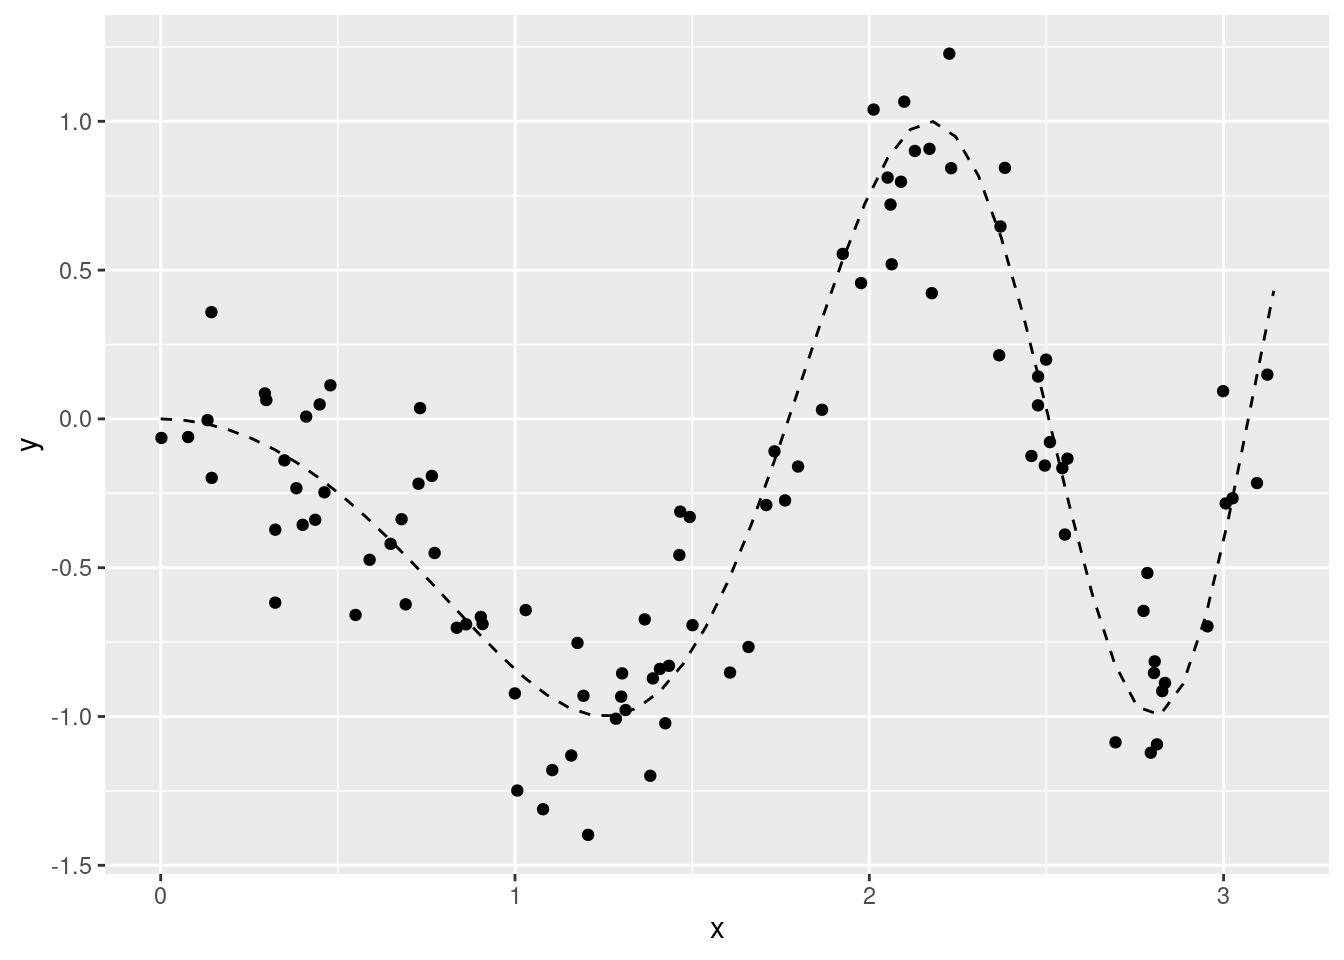

In [ ]:
n <- 100
set.seed(123)
df <- data.frame(x = runif(n, min = 0, max = pi))
df$y <- sin(df$x^2 - pi) + rnorm(n, sd = .25)
nd <- data.frame(x = seq(0, pi, length.out = 50))
nd$mu <- sin(nd$x^2 - pi)
ggplot(data = df, aes(x = x)) + 
  geom_point(aes(y = y)) + 
  geom_line(data = nd, aes(y = mu), linetype = "dashed")

A suitable model can be implemented using the function `mgcv::gam`, with in especially usage of the function `mgcv:s()`:

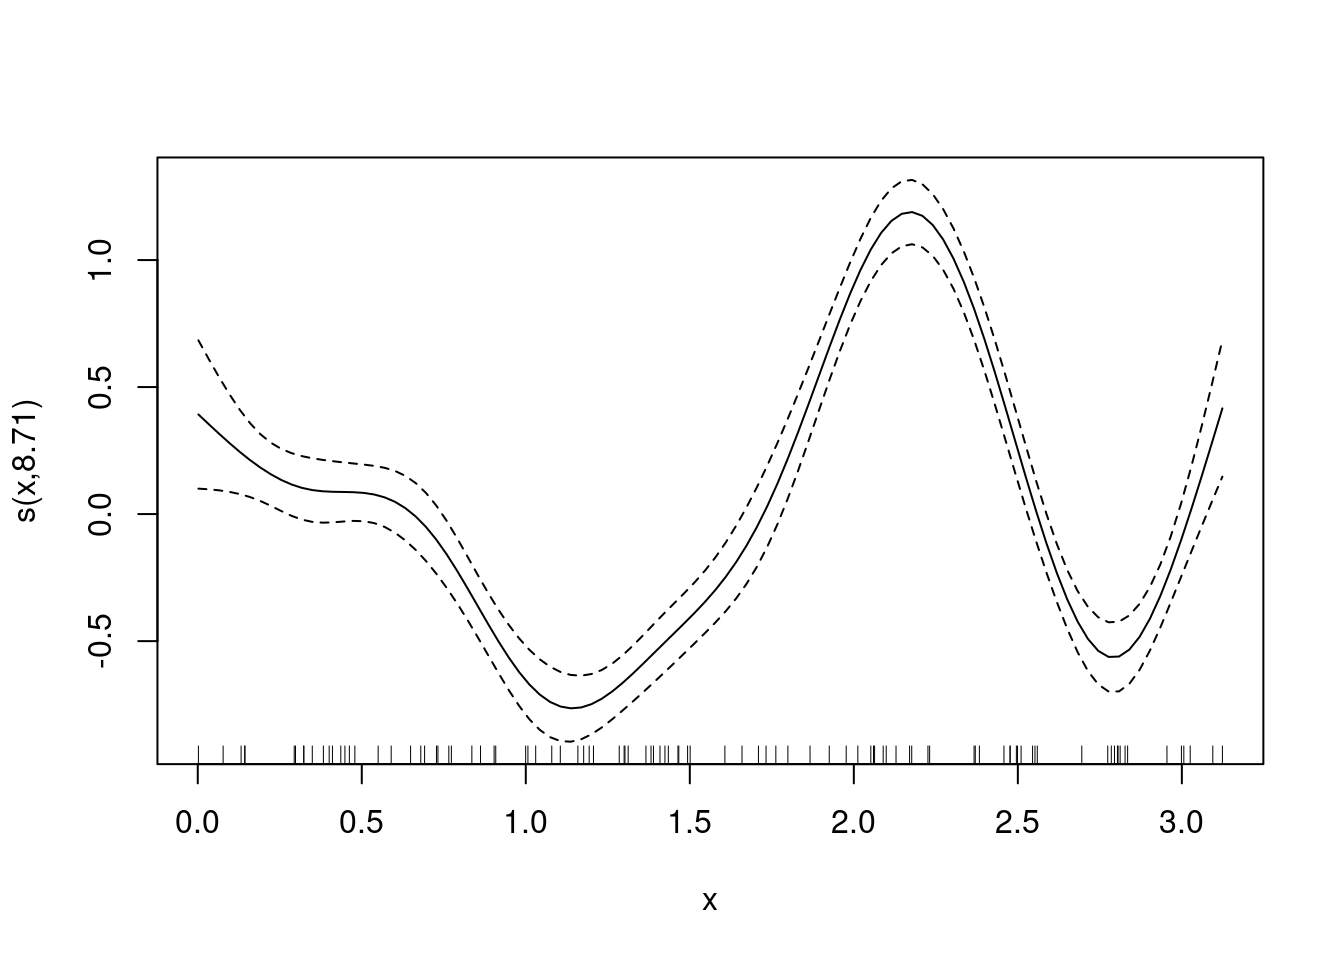

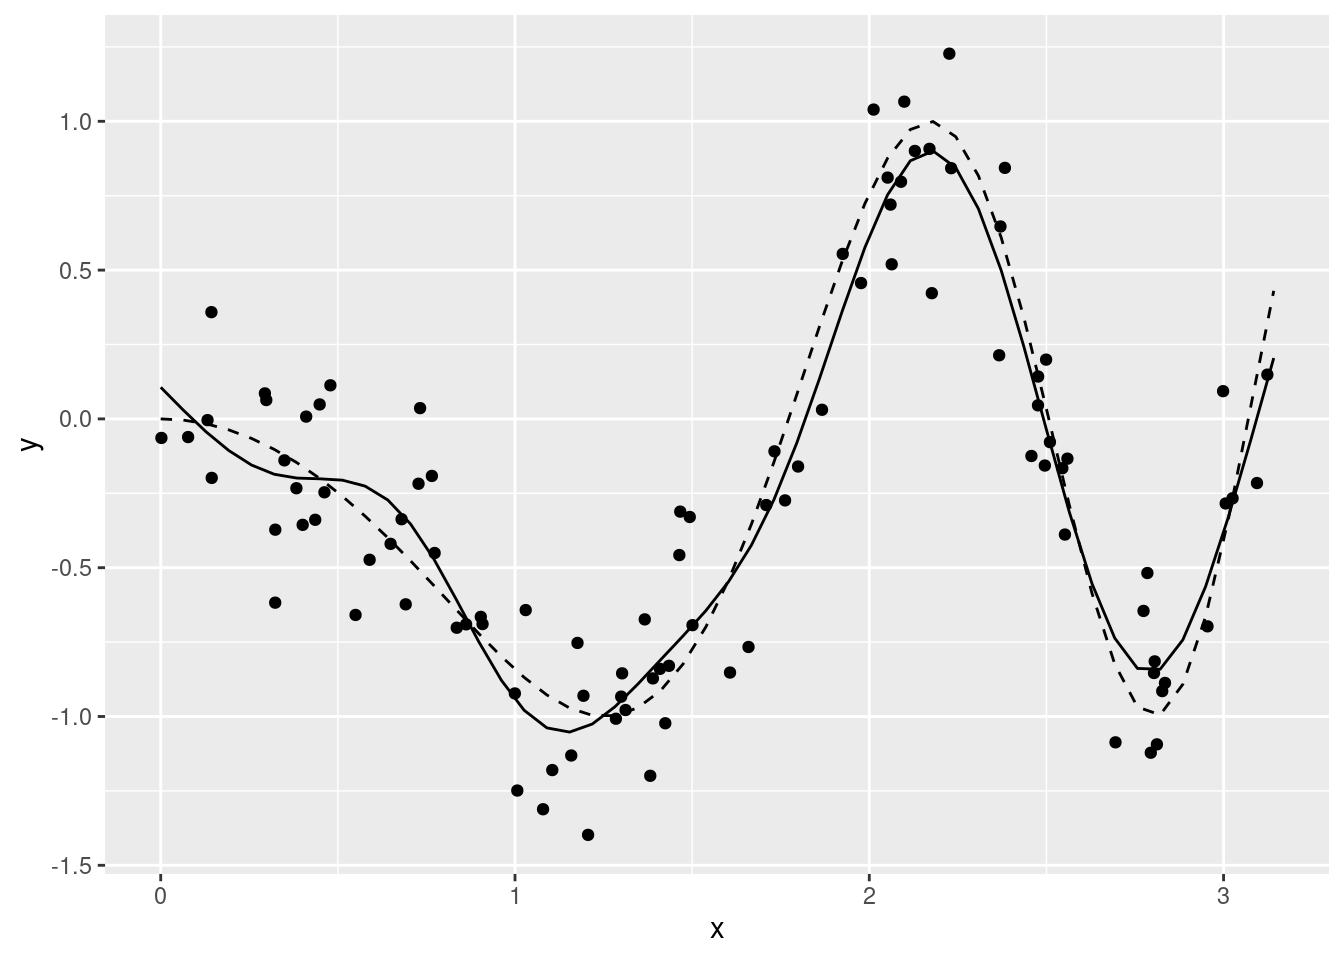

In [ ]:
m <- gam(y ~ s(x), data = df)
plot(m)

What does `s()` do?

  (Intercept)    s(x).1     s(x).2   s(x).3     s(x).4    s(x).5     s(x).6
1           1 -1.110390 -0.7863538 1.327113 -1.0156741 -1.389606 -0.5755292
2           1 -1.112745 -0.7620022 1.330739 -0.9857403 -1.394499 -0.5443745
3           1 -1.114827 -0.7374878 1.332975 -0.9534962 -1.395550 -0.5091587
4           1 -1.116216 -0.7124827 1.331685 -0.9156141 -1.387345 -0.4648478
5           1 -1.116234 -0.6862777 1.323491 -0.8674136 -1.362650 -0.4065304
6           1 -1.114115 -0.6580194 1.304598 -0.8038132 -1.313750 -0.3295964
     s(x).7     s(x).8    s(x).9
1 -1.841987 -0.6428615 -1.758172
2 -1.836490 -0.5718634 -1.686202
3 -1.820364 -0.5005500 -1.614233
4 -1.780468 -0.4285334 -1.542263
5 -1.704336 -0.3554311 -1.470294
6 -1.580454 -0.2808812 -1.398324

  Var1        Var2 value
1    1 (Intercept)     1
2    2 (Intercept)     1
3    3 (Intercept)     1
4    4 (Intercept)     1
5    5 (Intercept)     1
6    6 (Intercept)     1

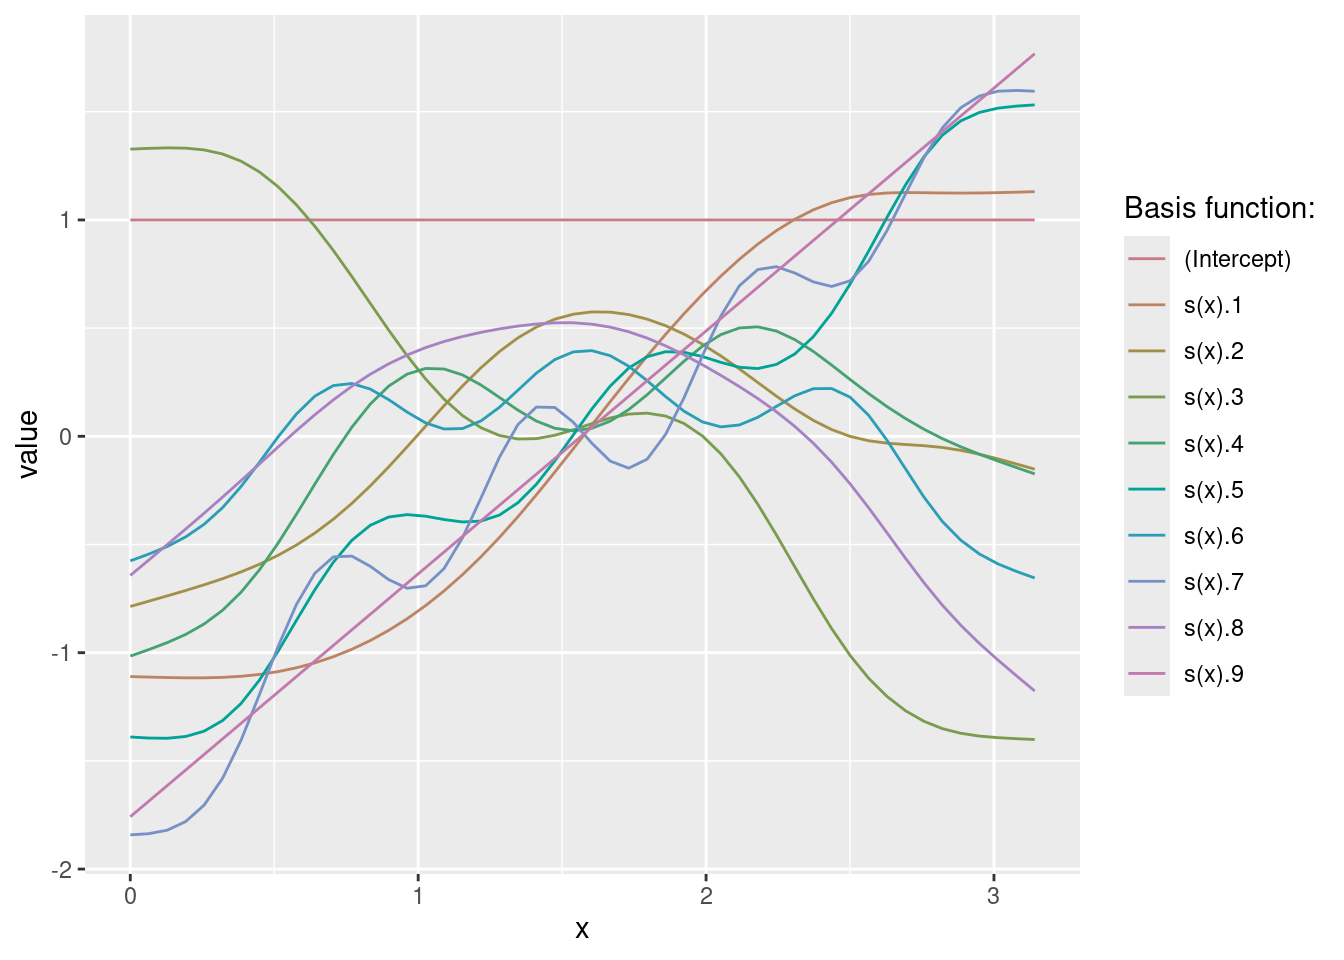

(Intercept)      s(x).1      s(x).2      s(x).3      s(x).4      s(x).5 
 -0.2883327   0.1328587   3.3990351   2.6033203   3.3949996  -1.9450739 
     s(x).6      s(x).7      s(x).8      s(x).9 
  2.6219341  -0.1327275  -6.4627018   1.3564139 

ℹ Please use `linewidth` instead.

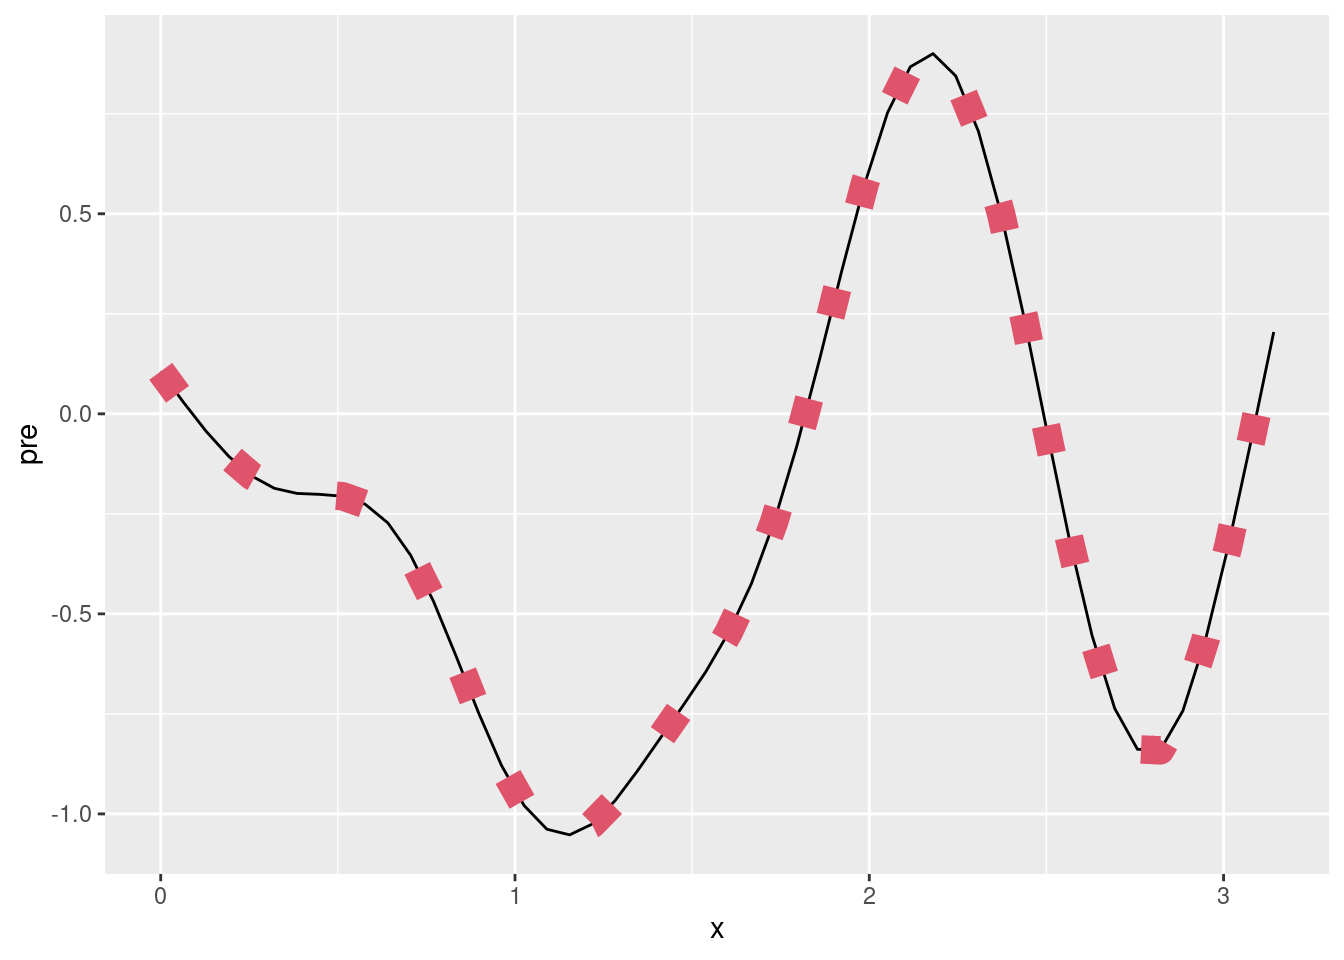

In [ ]:
X <- predict(m, newdata = nd, type = "lpmatrix")
head(X)

How does `mgcv` quantify uncertainty and how can we interpret this uncertainty?

     (Intercept)      s(x).1   s(x).2   s(x).3   s(x).4    s(x).5   s(x).6
[1,]  -0.2969723  0.14827346 2.845380 2.472228 2.986735 -2.025393 2.321902
[2,]  -0.2798226  0.45813882 2.791453 2.539675 2.988796 -1.225334 1.925825
[3,]  -0.2989047  0.02970708 3.627493 2.644463 3.434373 -1.716172 2.719180
[4,]  -0.2998487 -0.16155372 4.105077 2.831955 3.863112 -2.421325 3.100904
[5,]  -0.3156754  0.32549077 3.244017 2.692452 3.153326 -1.978761 2.526919
[6,]  -0.2895788  0.11326272 1.954769 2.364647 2.358708 -1.651279 1.594067
          s(x).7    s(x).8    s(x).9
[1,] -0.10699650 -5.629549 1.6480470
[2,] -0.15590646 -5.349300 0.8544413
[3,] -0.32639388 -6.690499 1.3949870
[4,] -0.30574994 -7.587330 1.9507888
[5,]  0.07690747 -6.235893 1.2065182
[6,] -0.05222090 -4.137128 1.8122858

  Var1 Var2       value
1    1    1 -0.05497982
2    2    1  0.16933401
3    3    1  0.10640081
4    4    1  0.07715345
5    5    1  0.18366364
6    6    1 -0.26333221

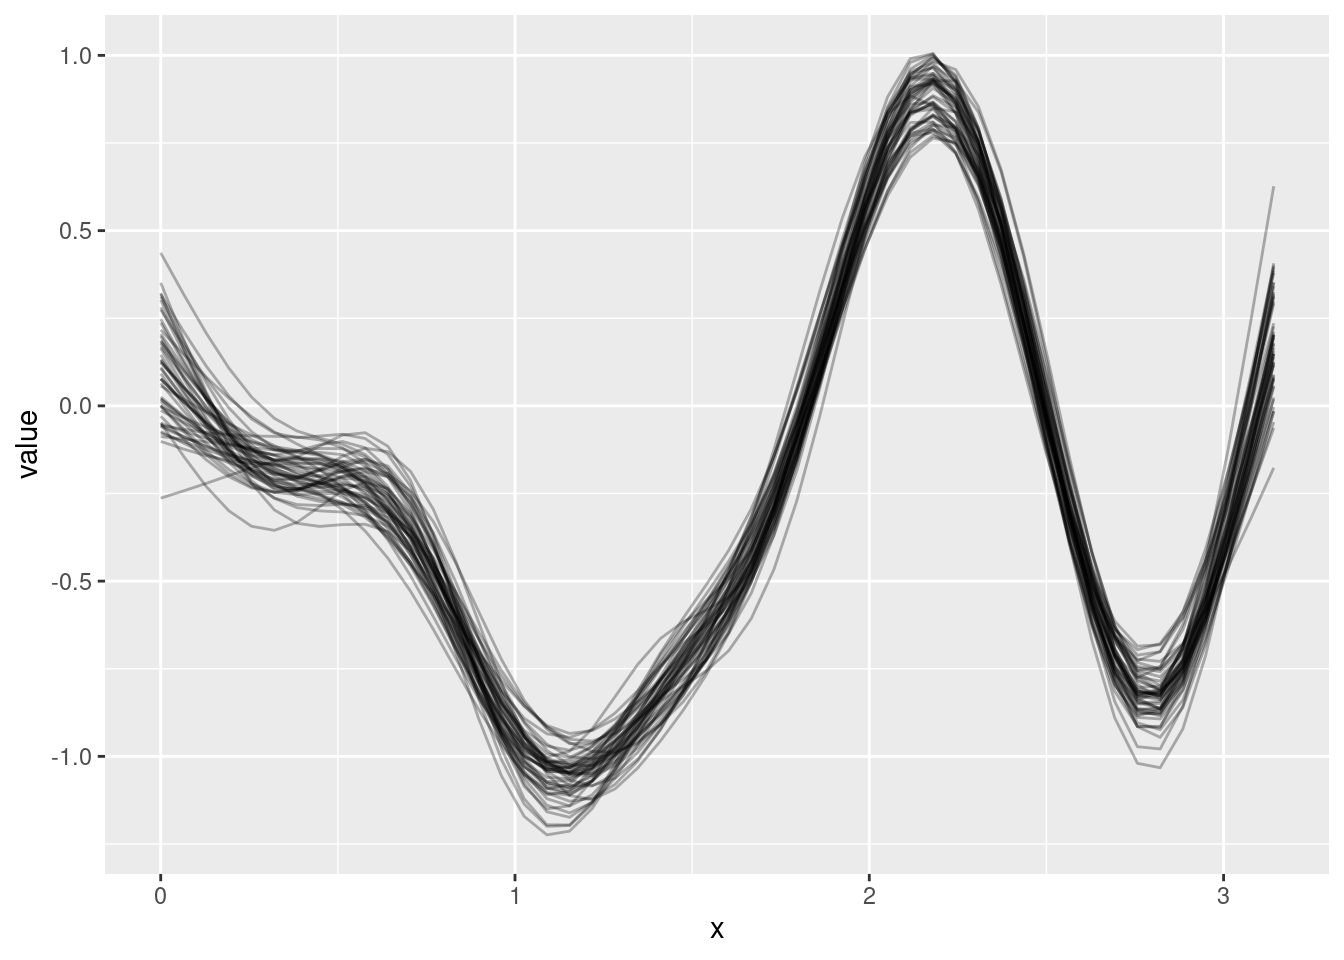

[1] -0.2883327

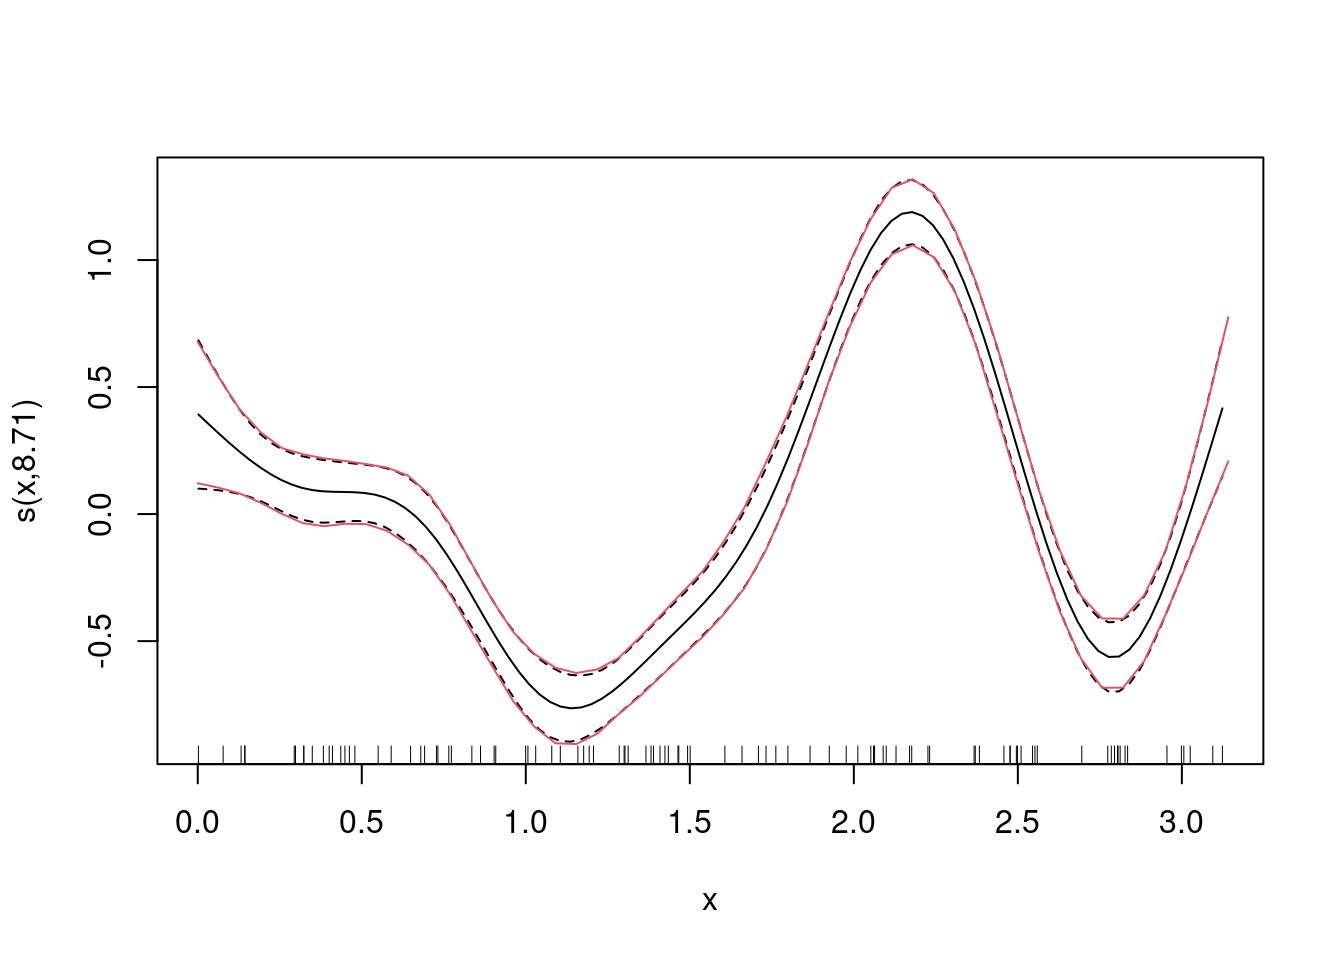

In [ ]:
B <- rmvn(50, coef(m), vcov(m))
head(B)

## GAM with bivariate effect surface

Let’s see how a ‘spatial’ effect is estimated?

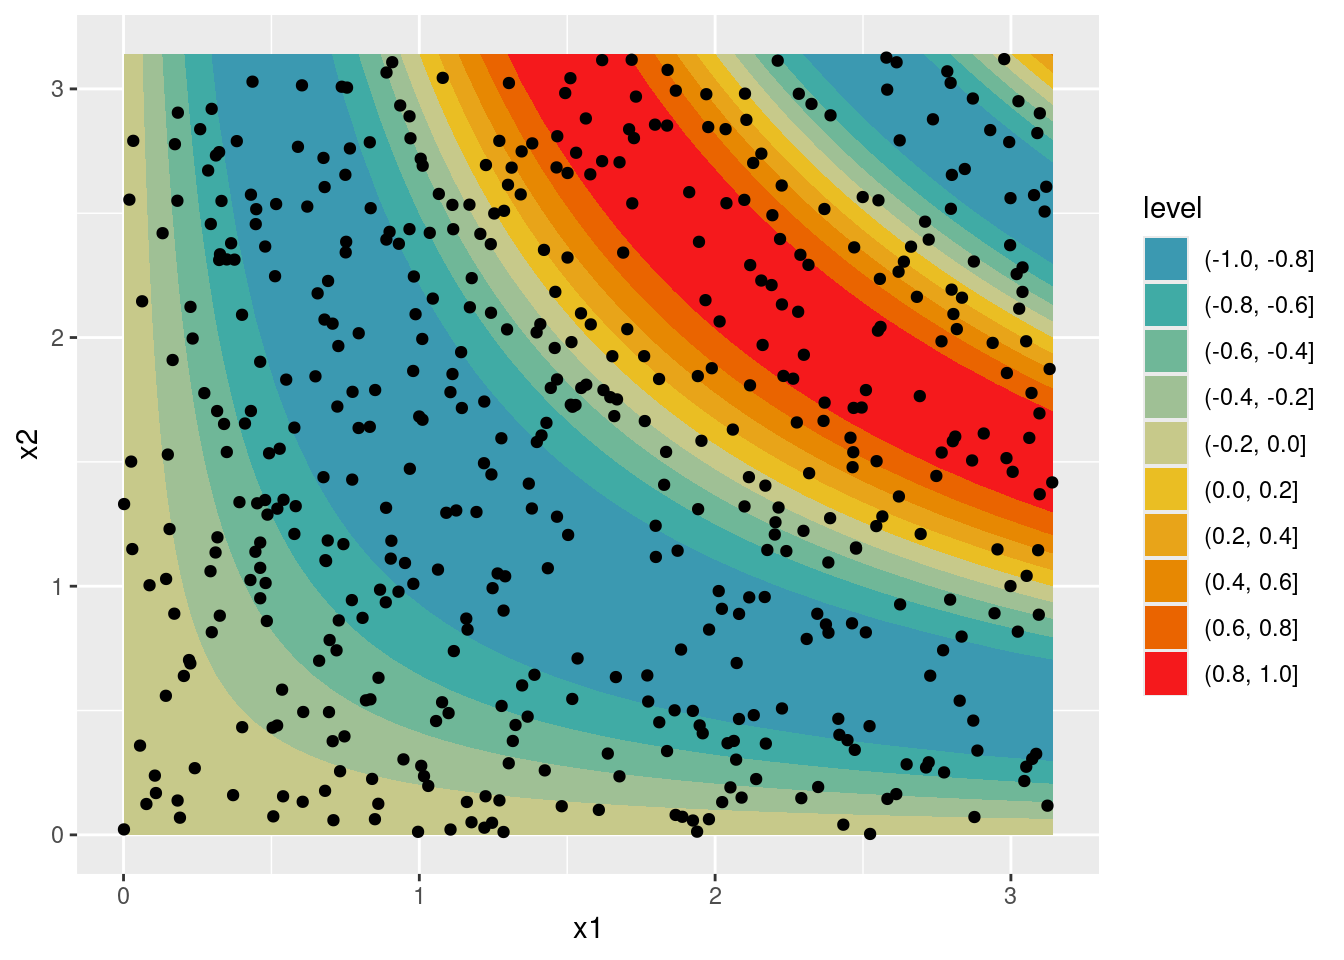

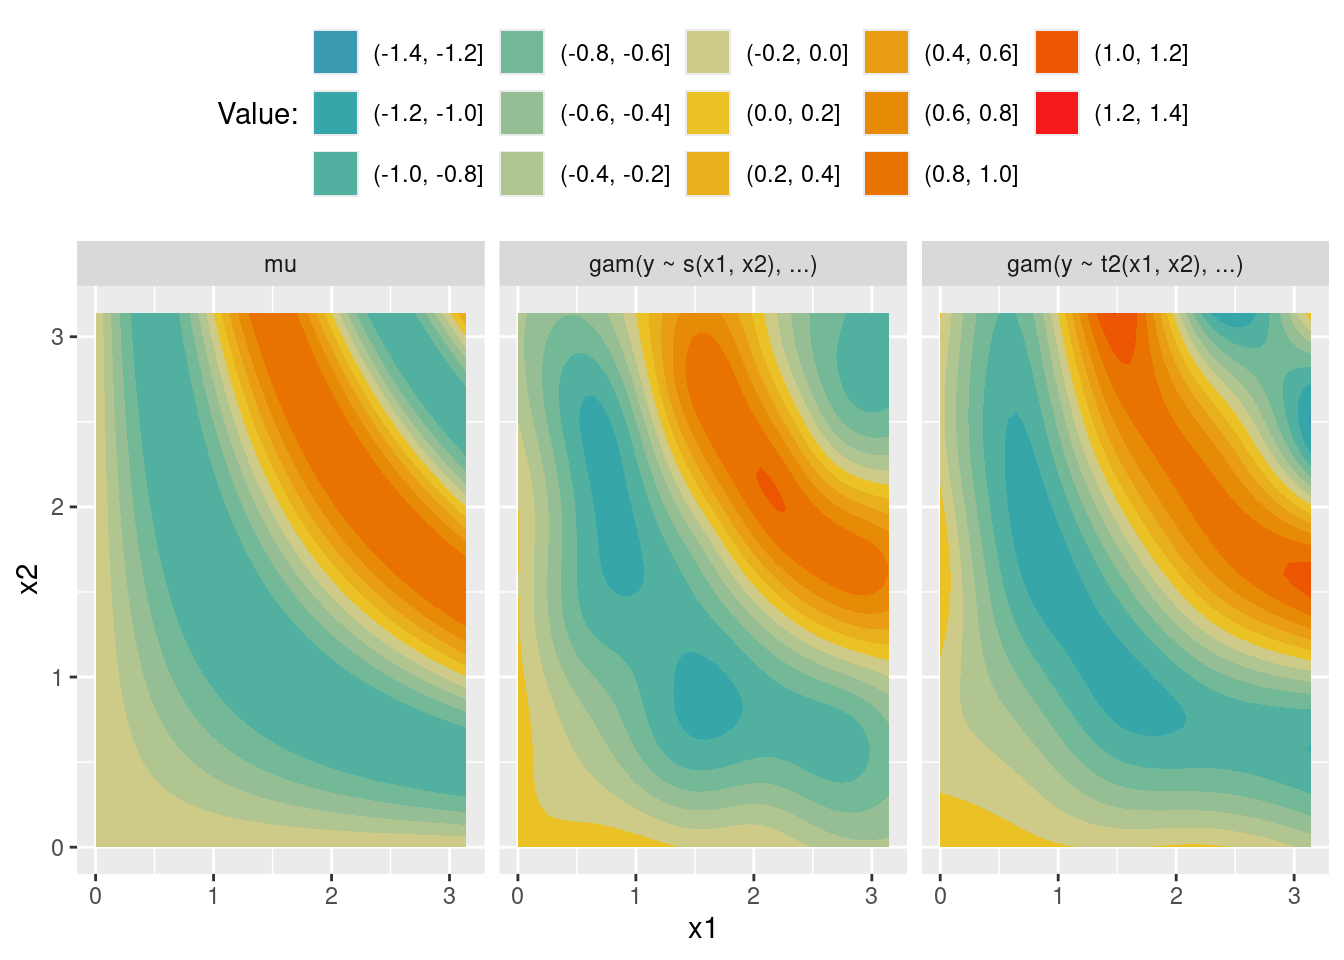

In [ ]:
n <- 500
set.seed(123)
df <- data.frame(x1 = runif(n, min = 0, max = pi),
                 x2 = runif(n, min = 0, max = pi))
df$y <- sin(df$x1 * df$x2 - pi) + rnorm(n, sd = .25)
nd <- expand.grid('x1' = seq(0, pi, length.out = 50),
                  'x2' = seq(0, pi, length.out = 50))
nd$mu <- sin(nd$x1 * nd$x2 - pi)
ggplot(data = nd, aes(x = x1, y = x2)) + 
  geom_contour_filled(aes(z = mu)) +
  geom_point(data = df) + 
  scale_fill_discrete_divergingx(pal = "Zissou")

  (Intercept) s(x1,x2).1 s(x1,x2).2 s(x1,x2).3  s(x1,x2).4  s(x1,x2).5
1           1   1.976689 0.03371151  0.3304568 -0.00259226  0.17111069
2           1   1.953387 0.12968114  0.3370067  0.03879382  0.10776499
3           1   1.924786 0.22810439  0.3459613  0.08379769  0.03947457
4           1   1.890669 0.32877303  0.3576584  0.13285743 -0.03302845
5           1   1.850898 0.43139923  0.3722188  0.18626423 -0.10880938
6           1   1.805536 0.53566289  0.3894894  0.24424418 -0.18664853
  s(x1,x2).6 s(x1,x2).7 s(x1,x2).8 s(x1,x2).9 s(x1,x2).10 s(x1,x2).11
1 -0.5733509  0.8731026  -2.546673 0.08897994  -0.4737068  0.09007722
2 -0.5875089  0.9045996  -2.406345 0.20978069  -0.4791941  0.15745018
3 -0.6019473  0.9322257  -2.247393 0.34624806  -0.4797606  0.24512764
4 -0.6168661  0.9548019  -2.071011 0.49751798  -0.4743269  0.35294021
5 -0.6322095  0.9713239  -1.879590 0.66173468  -0.4617458  0.47919667
6 -0.6478180  0.9808658  -1.677758 0.83608598  -0.4410087  0.61933769
   s(x1,x2).1

  Var1        Var2 value
1    1 (Intercept)     1
2    2 (Intercept)     1
3    3 (Intercept)     1
4    4 (Intercept)     1
5    5 (Intercept)     1
6    6 (Intercept)     1

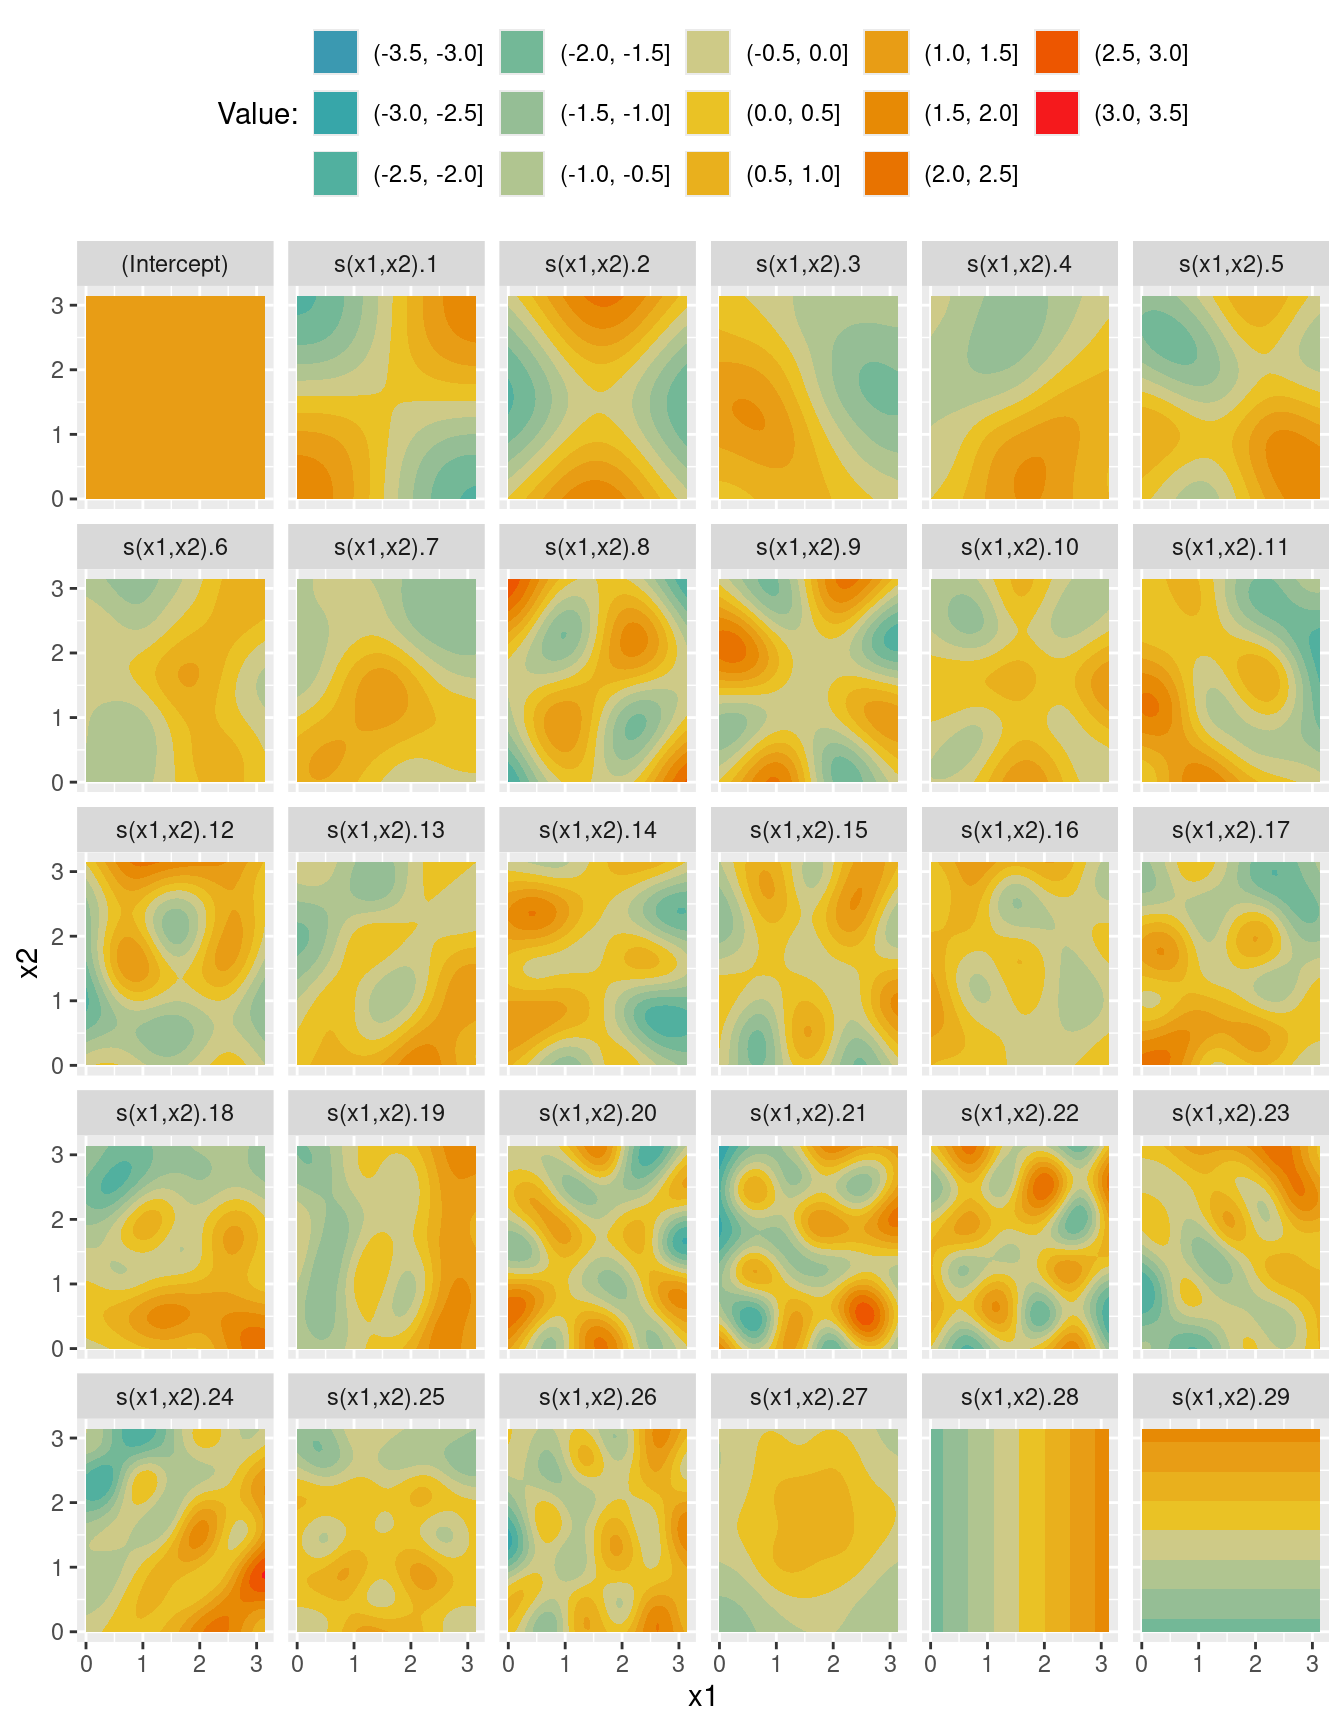

In [ ]:
X <- predict(m_s, newdata = nd, type = "lpmatrix")
head(X)

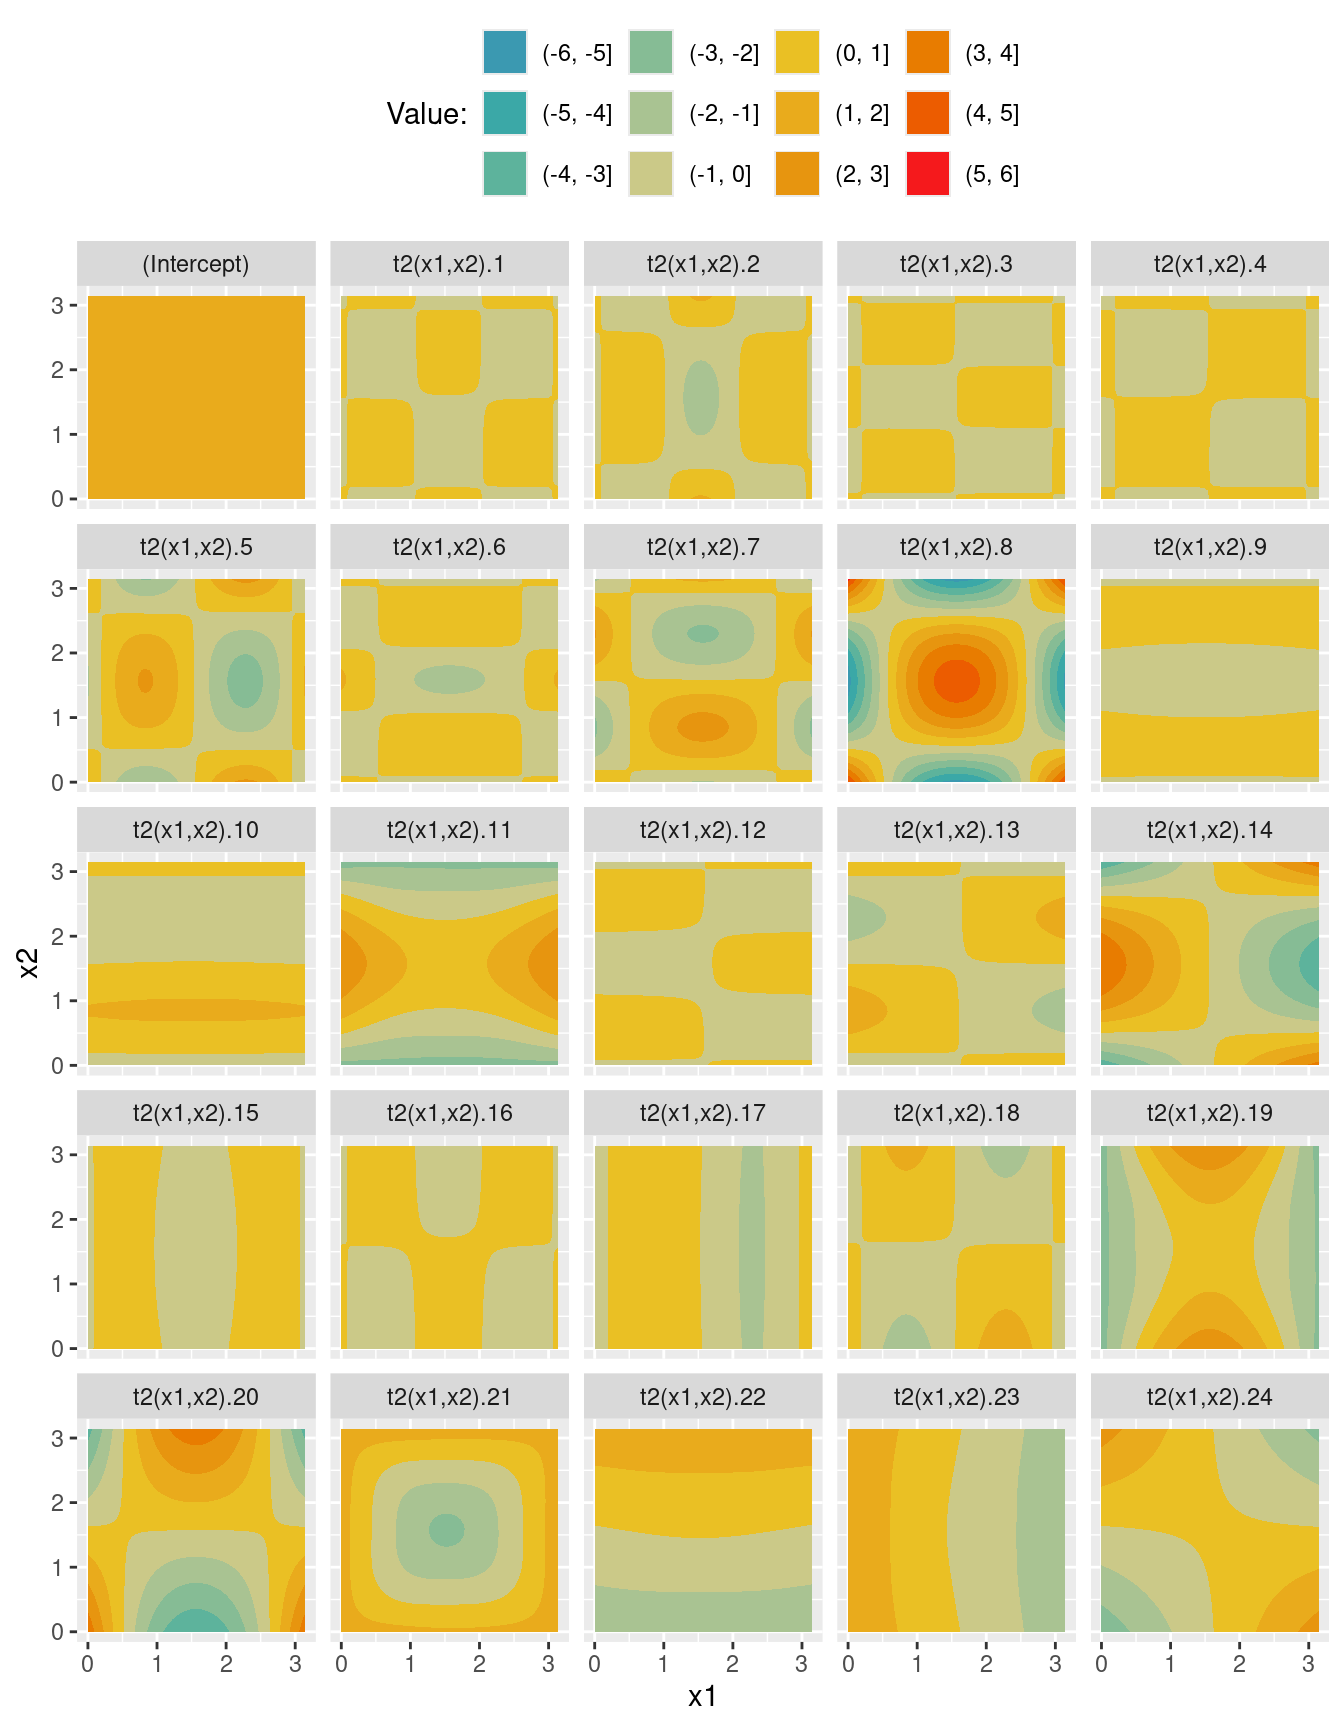

In [ ]:
X <- predict(m_t2, newdata = nd, type = "lpmatrix")
Xd <- reshape2::melt(X)
Xd$x1 <- nd$x1[Xd$Var1]
Xd$x2 <- nd$x2[Xd$Var1]
ggplot(data = Xd, aes(x = x1, y = x2)) + 
  geom_contour_filled(aes(z = value)) +
  facet_wrap(~ Var2) + 
  theme(legend.position = "top") + 
  labs(fill = "Value:") + 
  scale_fill_discrete_divergingx(pal = "Zissou")

## Meet the `ocat` family …

In order to specifiy an orderled logistic regression in `mgcv`, we need to specify the `family` attribute as `ocat`:

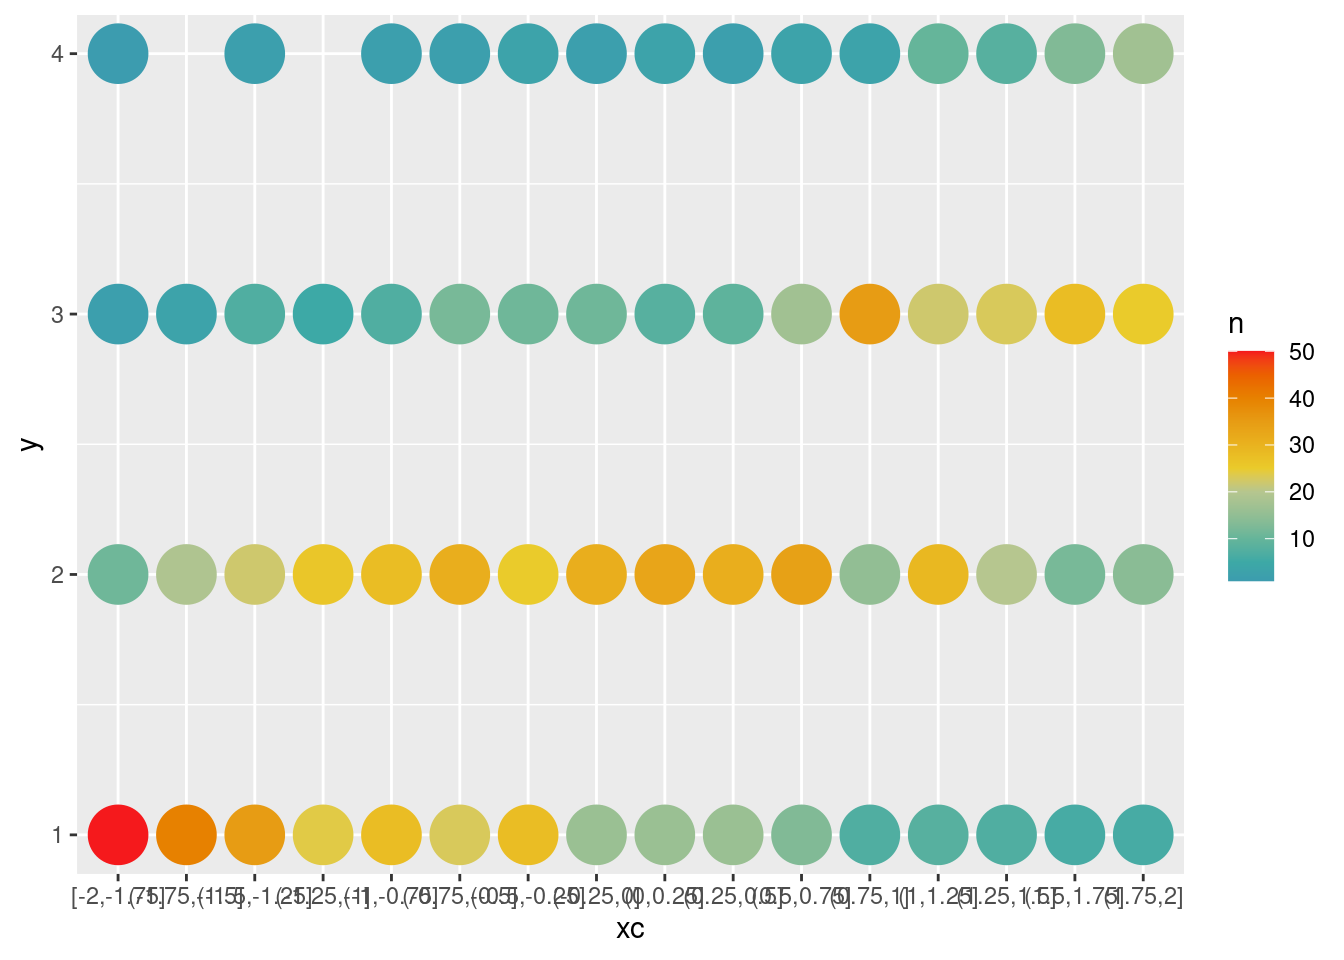

In [ ]:
rm(list = ls())
get_prob <- function(lp, theta) {
  R <- length(theta)
  prob <- matrix(0, length(lp), R + 2)
  prob[, R + 2] <- 1
  for (i in 1:R) {
    x <- theta[i] - lp
    ind <- x > 0
    prob[ind, i + 1] <- 1/(1 + exp(-x[ind]))
    ex <- exp(x[!ind])
    prob[!ind, i + 1] <- ex/(1 + ex)
  }
  prob <- t(diff(t(prob)))
  return(prob)
}
get_y <- function(alpha, eta) {
  R <- length(alpha) - 1
  n <- length(eta)
  y <- rep(NA, n)
  u <- eta + qlogis(runif(n)) ## df$mu + log(u/(1-u))
  for (i in 1:R) {
    y[(u > alpha[i]) & (u <= alpha[i + 1])] <- i
  }
  return(y)
}
set.seed(123)
n <- 1000
x <- runif(n, min = -2, max = 2)
df <- data.frame(x = x, 
                 eta = x)
alpha <- c(-Inf, -1, 1, 3, Inf)
df$y <- get_y(alpha, df$eta)
df$xc <- cut(df$x, breaks = seq(-2, 2, by = .25), include.lowest = T)
ggplot(data = df, aes(x = xc, y = y)) + 
  geom_count(aes(color = after_stat(n)), size = 10) + 
  scale_color_continuous_divergingx(pal = "Zissou", mid = 25)

     xc
y     [-2,-1.75] (-1.75,-1.5] (-1.5,-1.25] (-1.25,-1] (-1,-0.75] (-0.75,-0.5]
  1           50           40           35         24         28           23
  2           11           19           22         26         28           31
  3            2            3            7          5          7           12
  4            1            0            2          0          2            2
  Sum         64           62           66         55         65           68
     xc
y     (-0.5,-0.25] (-0.25,0] (0,0.25] (0.25,0.5] (0.5,0.75] (0.75,1] (1,1.25]
  1             28        16       16         16         13        7        8
  2             25        31       33         31         34       15       29
  3             11        11        8          9         17       35       22
  4              3         2        3          2          3        3       10
  Sum           67        60       60         58         67       60       69
     xc
y     (1.25,1.5] (1.5,1.75] (1.75,2]
  1

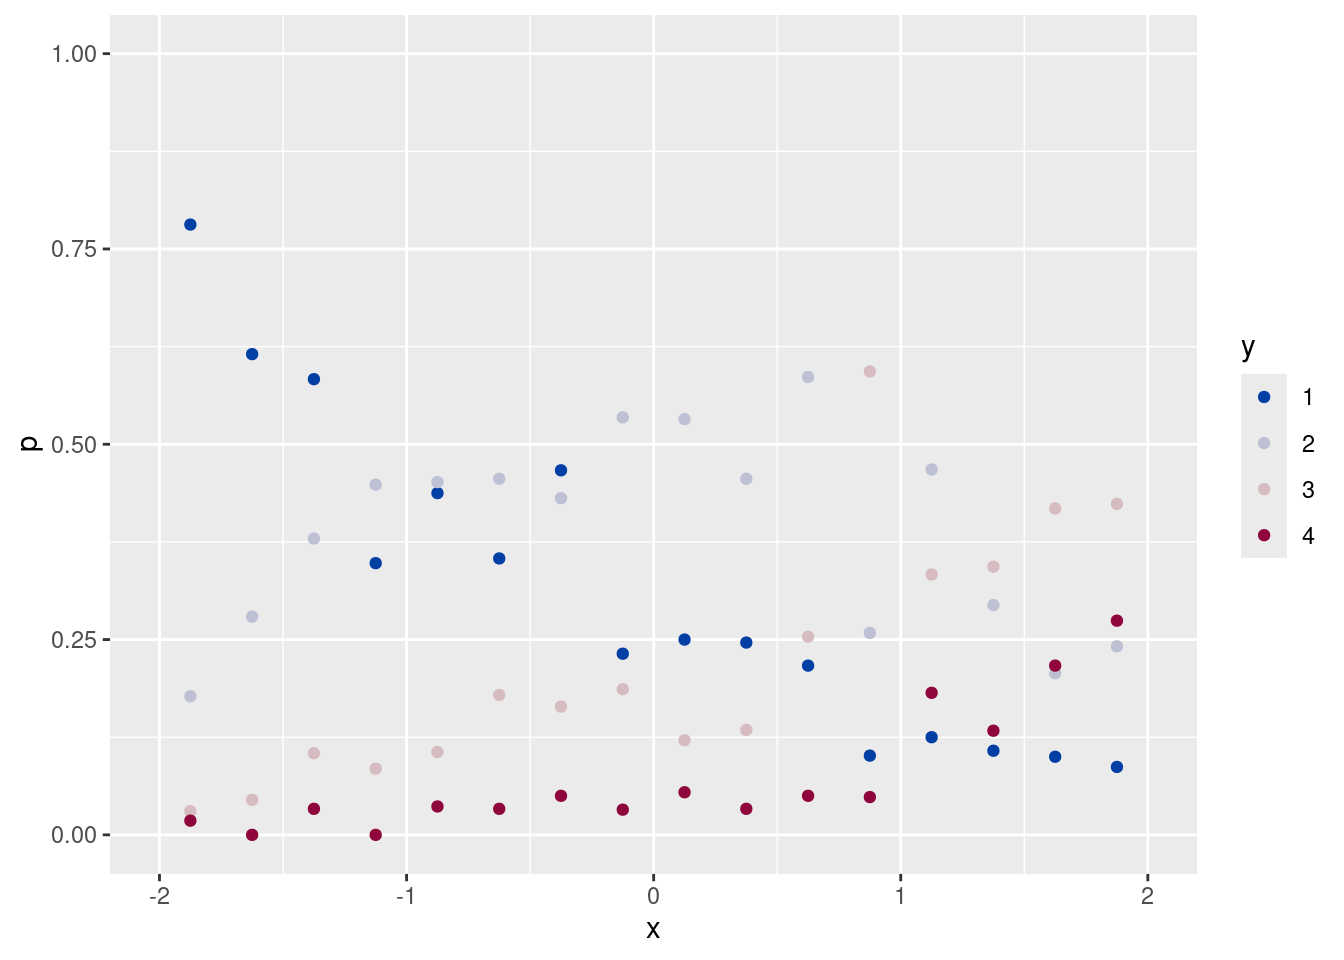

In [ ]:
(tmp <- addmargins(xtabs(~ y + xc, data = df), mar = 1))

In [ ]:
m <- gam(y ~ x, family = ocat(R = 4), data = df)
m$family$getTheta(TRUE)

[1] -1.000000  1.016038  2.978357

       [,1]      [,2]       [,3]        [,4]
1 0.7185518 0.2318687 0.04230184 0.007277626
2 0.6683642 0.2696485 0.05278585 0.009201425
3 0.6140344 0.3087177 0.06562008 0.011627813
4 0.5567073 0.3474112 0.08119694 0.014684548
5 0.4978290 0.3837381 0.09990317 0.018529778
6 0.4390108 0.4155539 0.12207729 0.023358032

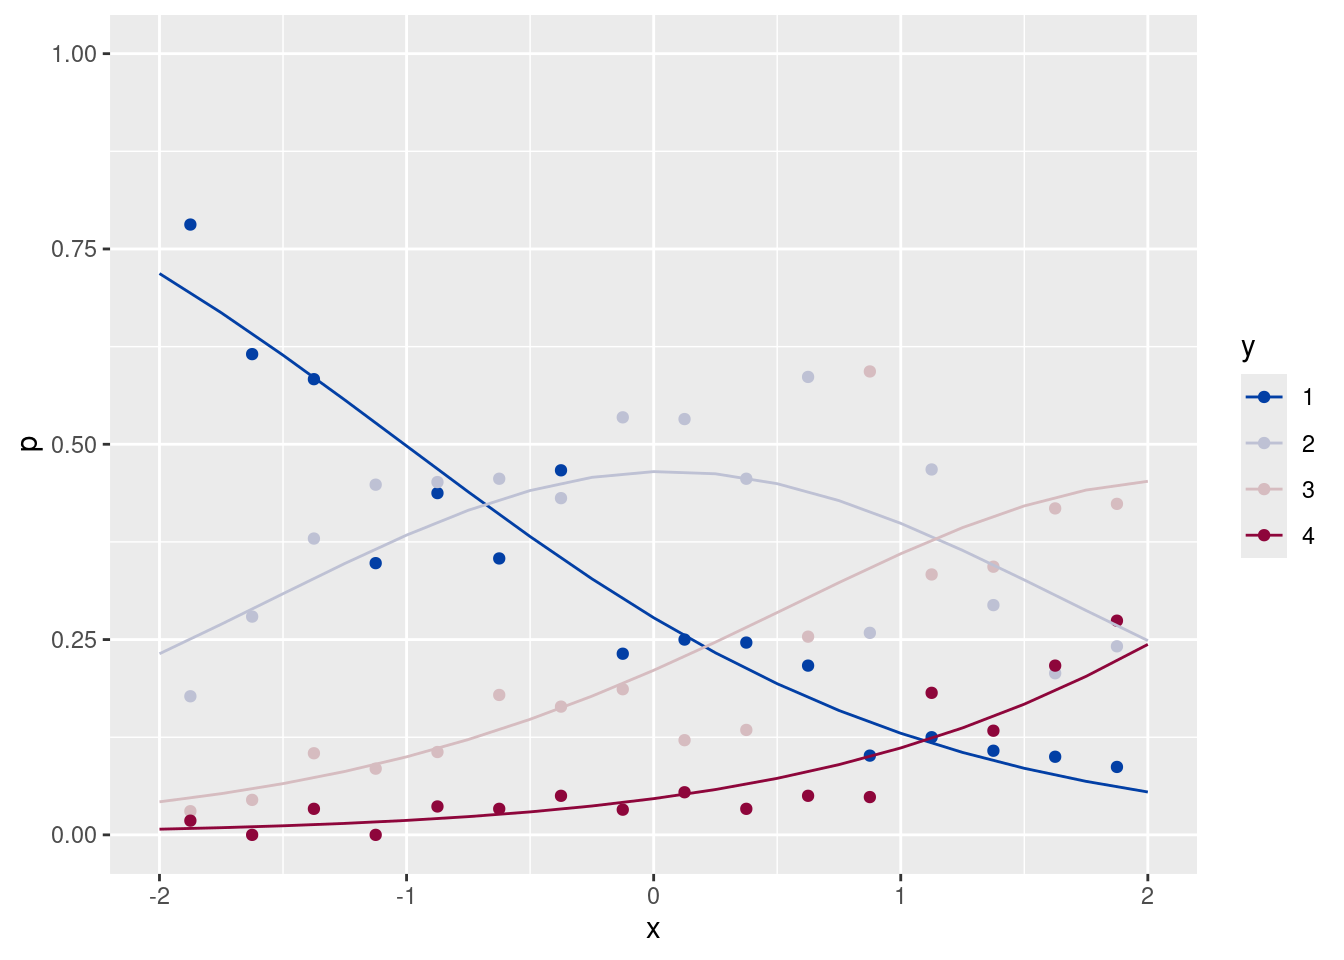

In [ ]:
nd <- data.frame(x = seq(-2, 2, by = .25))
pre <- NULL
pre_here <- predict(m, newdata = nd, type = "response")
head(pre_here)

      (Intercept)         x
[1,] -0.105028632 0.8930572
[2,] -0.046419889 0.9389411
[3,] -0.198145365 1.0089490
[4,] -0.030374057 1.0747553
[5,] -0.004272592 0.9200827
[6,]  0.122328585 1.0898455

[1] 1000   17

[1]   68 1000

            [,1]      [,2]       [,3]        [,4]
 [1,] 0.70912598 0.2390743 0.04418099 0.007618715
 [2,] 0.66102799 0.2750429 0.05442265 0.009506425
 [3,] 0.60935799 0.3119790 0.06680675 0.011856272
 [4,] 0.55511268 0.3484444 0.08166458 0.014778299
 [5,] 0.49952145 0.3827506 0.09932088 0.018407057
 [6,] 0.44394205 0.4130906 0.12006121 0.022906127
 [7,] 0.38973107 0.4377095 0.14408647 0.028472967
 [8,] 0.33811470 0.4550866 0.17145492 0.035343769
 [9,] 0.29008498 0.4641016 0.20201561 0.043797817
[10,] 0.24633870 0.4641590 0.23534177 0.054160495
[11,] 0.20726350 0.4552551 0.27067766 0.066803717
[12,] 0.17296407 0.4379780 0.30691584 0.082142052
[13,] 0.14331460 0.4134422 0.34262085 0.100622384
[14,] 0.11802234 0.3831640 0.37610903 0.122704596
[15,] 0.09668989 0.3488968 0.40558240 0.148830948
[16,] 0.07886846 0.3124477 0.42930113 0.179382695
[17,] 0.06409872 0.2755080 0.44576865 0.214624646

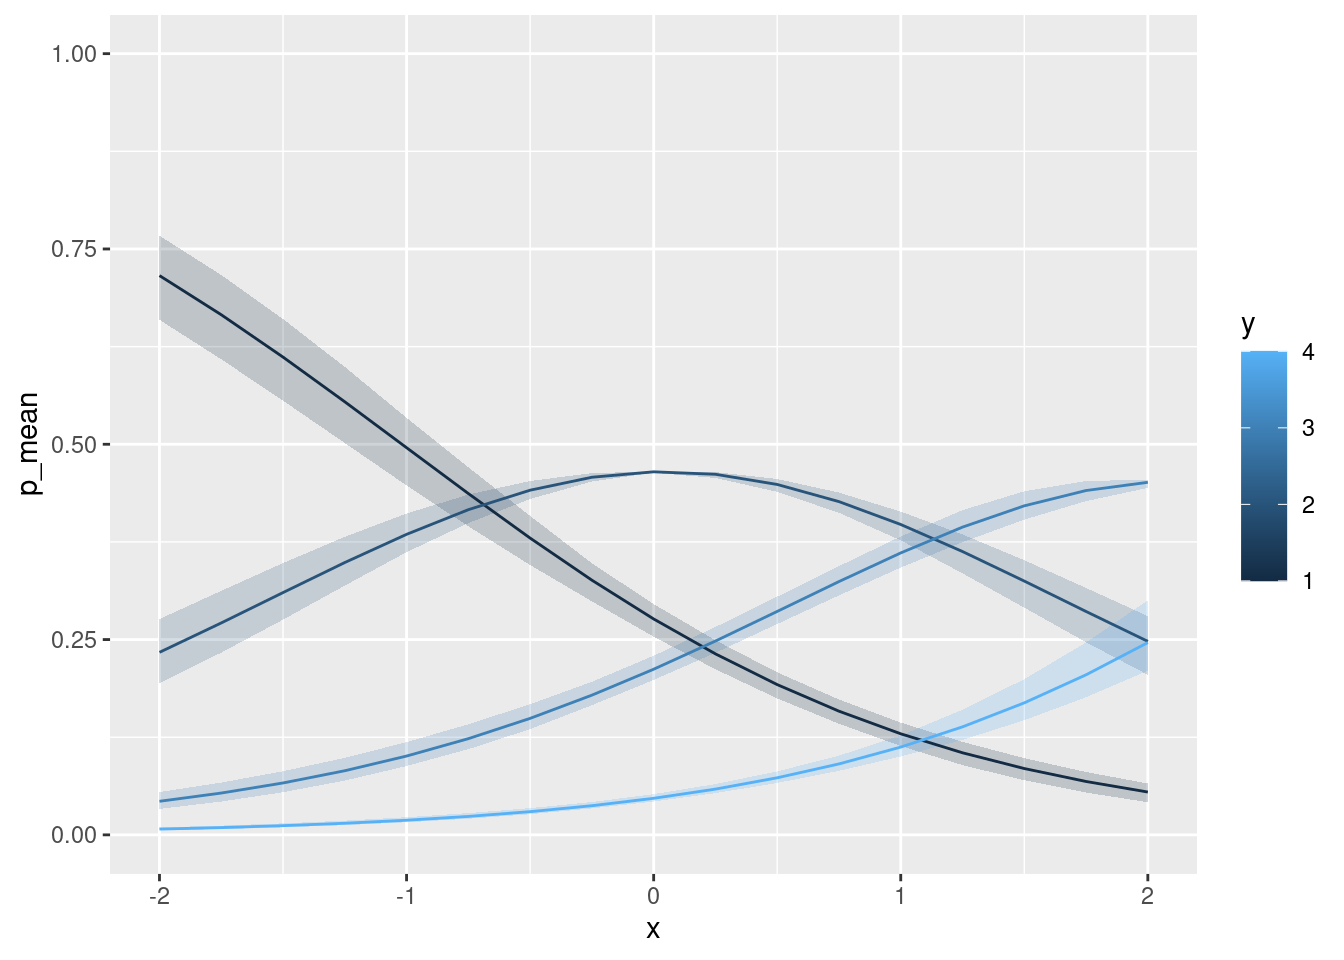

In [ ]:
X <- predict(m, newdata = nd, type = "lpmatrix")
## simulate directly from Gaussian approximate posterior...
B <- rmvn(1000, coef(m), vcov(m))
head(B)

… add a ‘smooth’ …

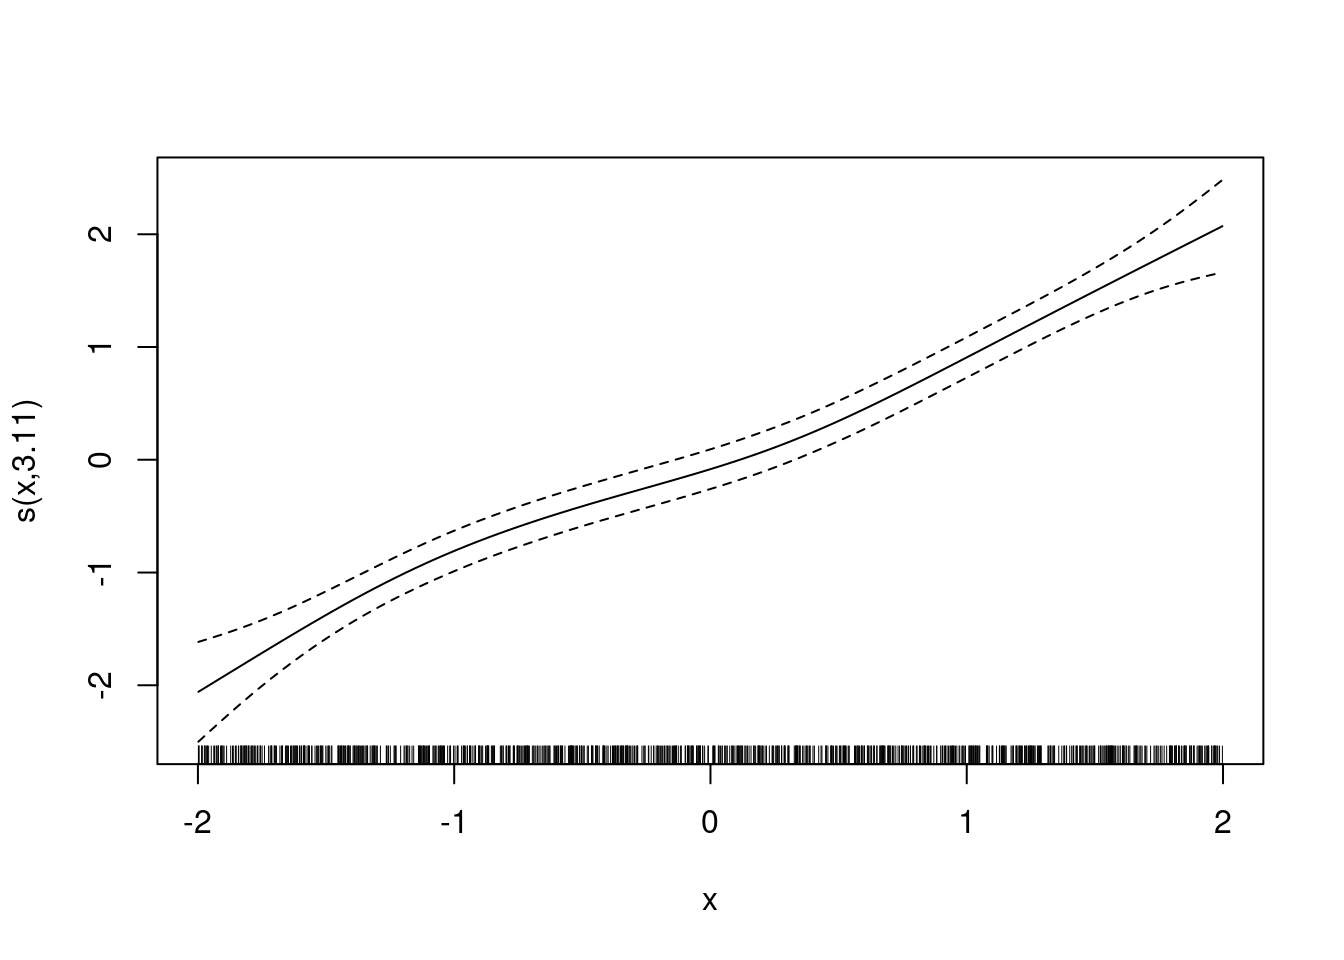

[1] -1.000000  1.015276  2.997751

In [ ]:
m <- gam(y ~ s(x), family = ocat(R = 4), data = df)
plot(m)

       [,1]      [,2]       [,3]        [,4]
1 0.7528150 0.2052566 0.03593709 0.005991324
2 0.6828033 0.2588899 0.04985119 0.008455591
3 0.6057981 0.3143940 0.06800380 0.011804091
4 0.5306624 0.3638872 0.08947424 0.015976125
5 0.4655438 0.4017491 0.11206784 0.020639208
6 0.4126987 0.4278687 0.13397439 0.025458164

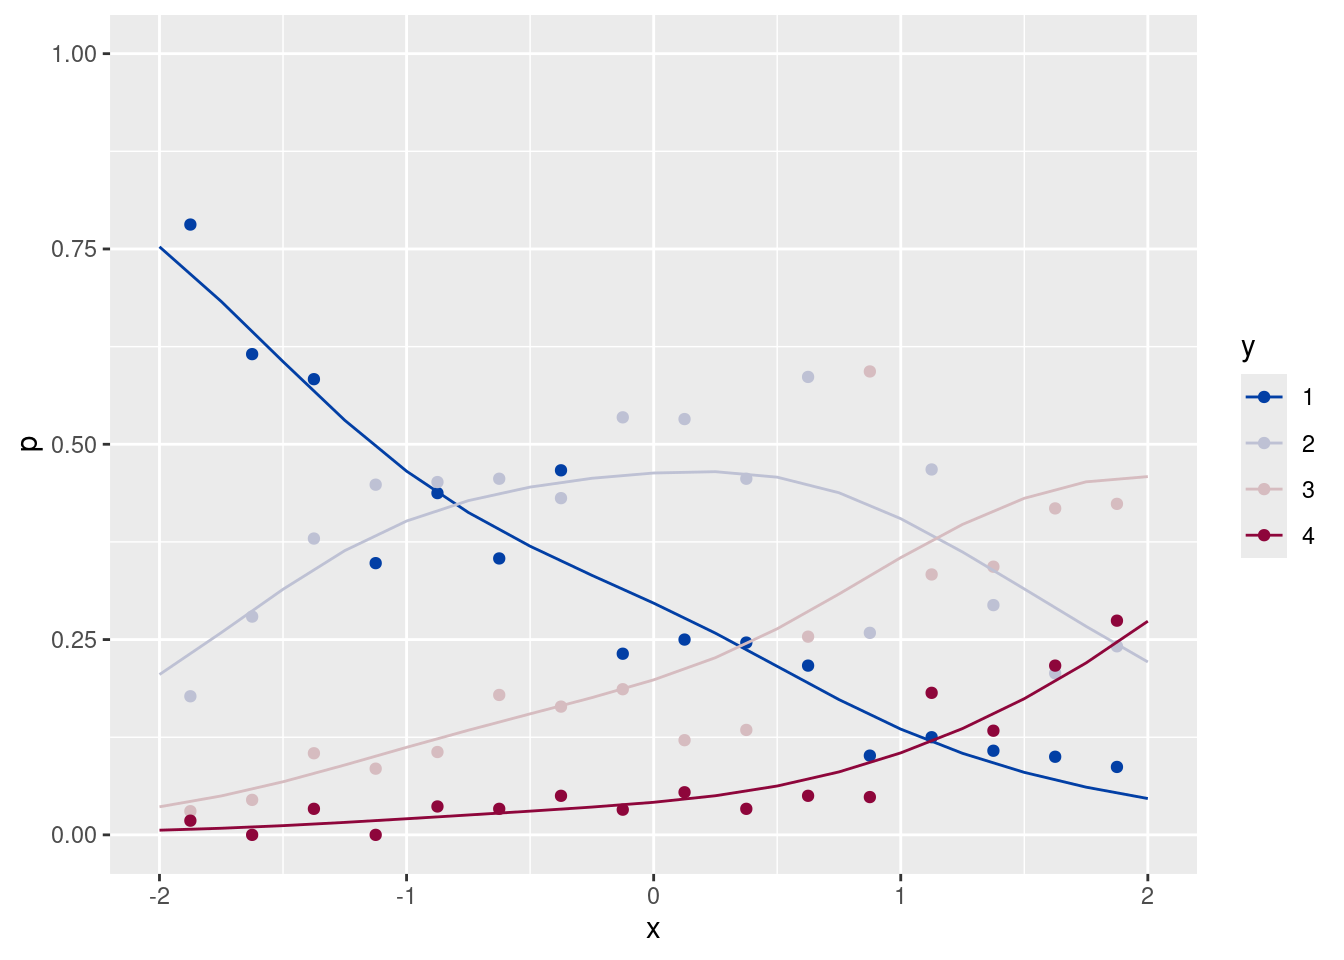

In [ ]:
nd <- data.frame(x = seq(-2, 2, by = .25))
pre <- NULL
pre_here <- predict(m, newdata = nd, type = "response")
head(pre_here)

In [ ]:
X <- predict(m, newdata = nd, type = "lpmatrix")
## simulate directly from Gaussian approximate posterior...
#B <- rmvn(1000, coef(m), vcov(m))
#head(B)
## Alternatively use MH sampling...
B <- gam.mh(m, thin = 2,ns=2000,rw.scale=.15)$bs

In [ ]:
# save(B, file = "B_m_ocat_smooth.RData")
load(file = "B_m_ocat_smooth.RData")

[1]   68 1000

            [,1]      [,2]       [,3]        [,4]
 [1,] 0.75047723 0.2070884 0.03636801 0.006066369
 [2,] 0.65301954 0.2808443 0.05647650 0.009659665
 [3,] 0.55385477 0.3491910 0.08238272 0.014571499
 [4,] 0.47461187 0.3968153 0.10865680 0.019916072
 [5,] 0.41787029 0.4255307 0.13166394 0.024935069
 [6,] 0.37742610 0.4423437 0.15083999 0.029390192
 [7,] 0.34812836 0.4521444 0.16649619 0.033231056
 [8,] 0.32106312 0.4590603 0.18250871 0.037367850
 [9,] 0.28404220 0.4644860 0.20724768 0.044224139
[10,] 0.23356921 0.4621532 0.24746382 0.056813764
[11,] 0.18044007 0.4424674 0.30013219 0.076960322
[12,] 0.13832609 0.4080436 0.35101412 0.102616177
[13,] 0.11098421 0.3726589 0.38816306 0.128193799
[14,] 0.09265203 0.3411394 0.41383132 0.152377306
[15,] 0.07525918 0.3038575 0.43683783 0.184045515
[16,] 0.05628693 0.2528658 0.45550573 0.235341571
[17,] 0.03977246 0.1973141 0.45582264 0.307090775

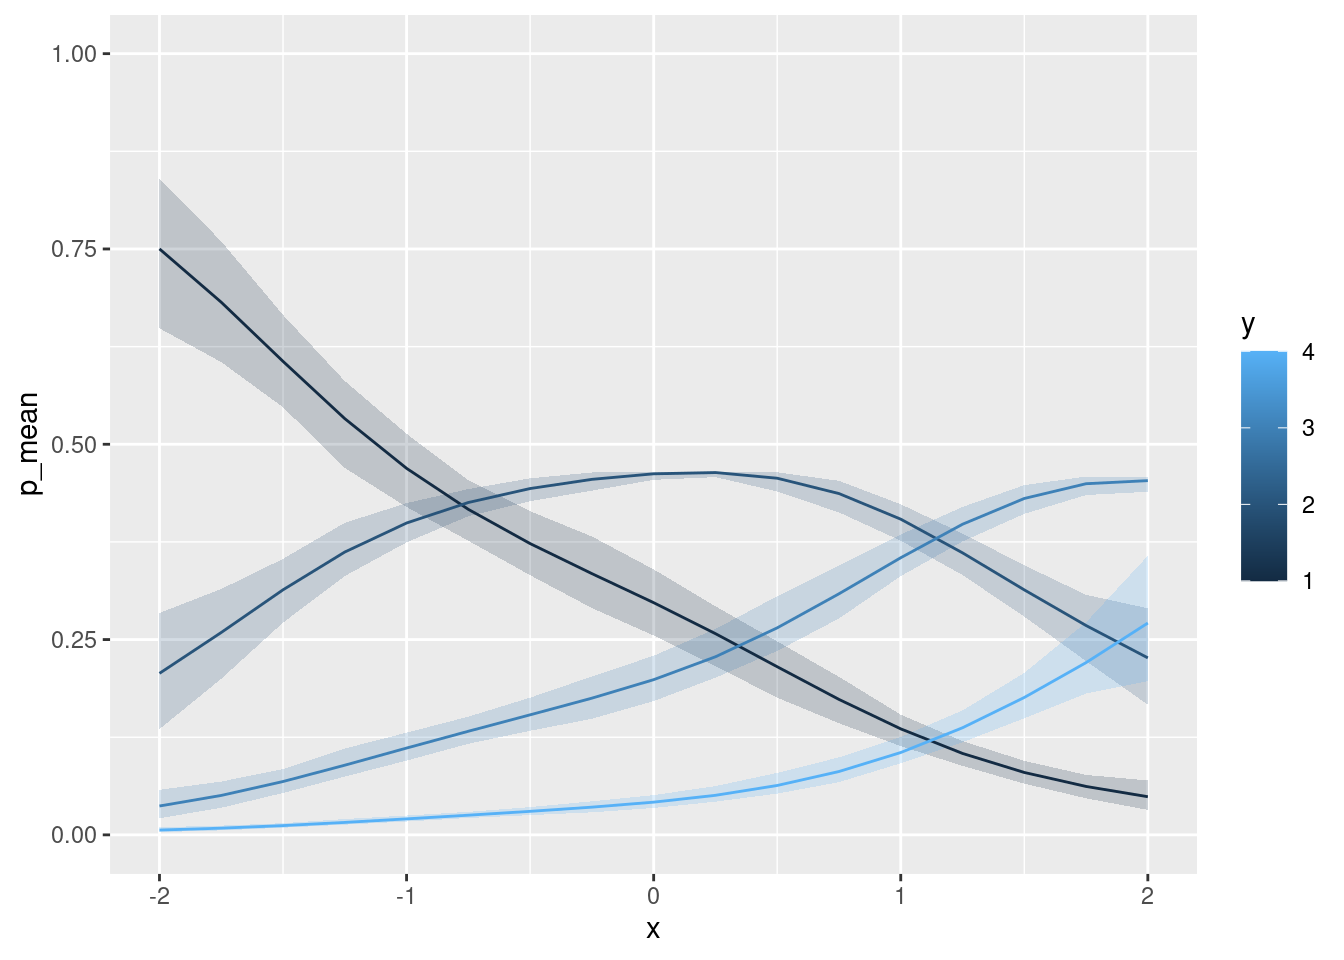

In [ ]:
E <- t(X %*% t(B))
theta <- m$family$getTheta(TRUE)
Ps <- apply(X = E, MARGIN = 1, FUN = get_prob, 
            theta = m$family$getTheta(TRUE))
dim(Ps)

## Distributional regression in `mgcv`

`?family.mgcv`

### `gaulss`

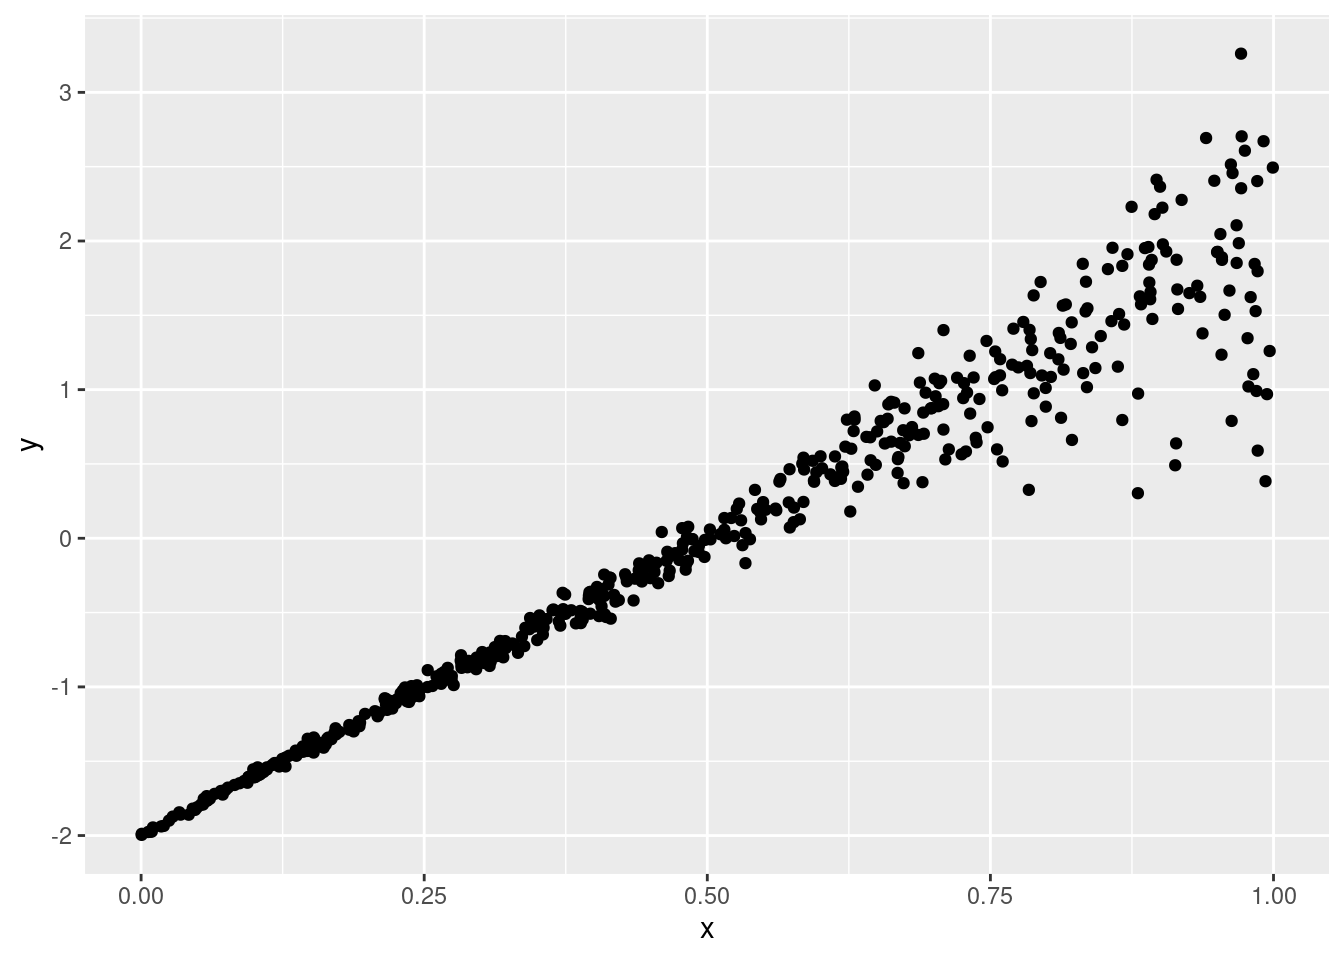

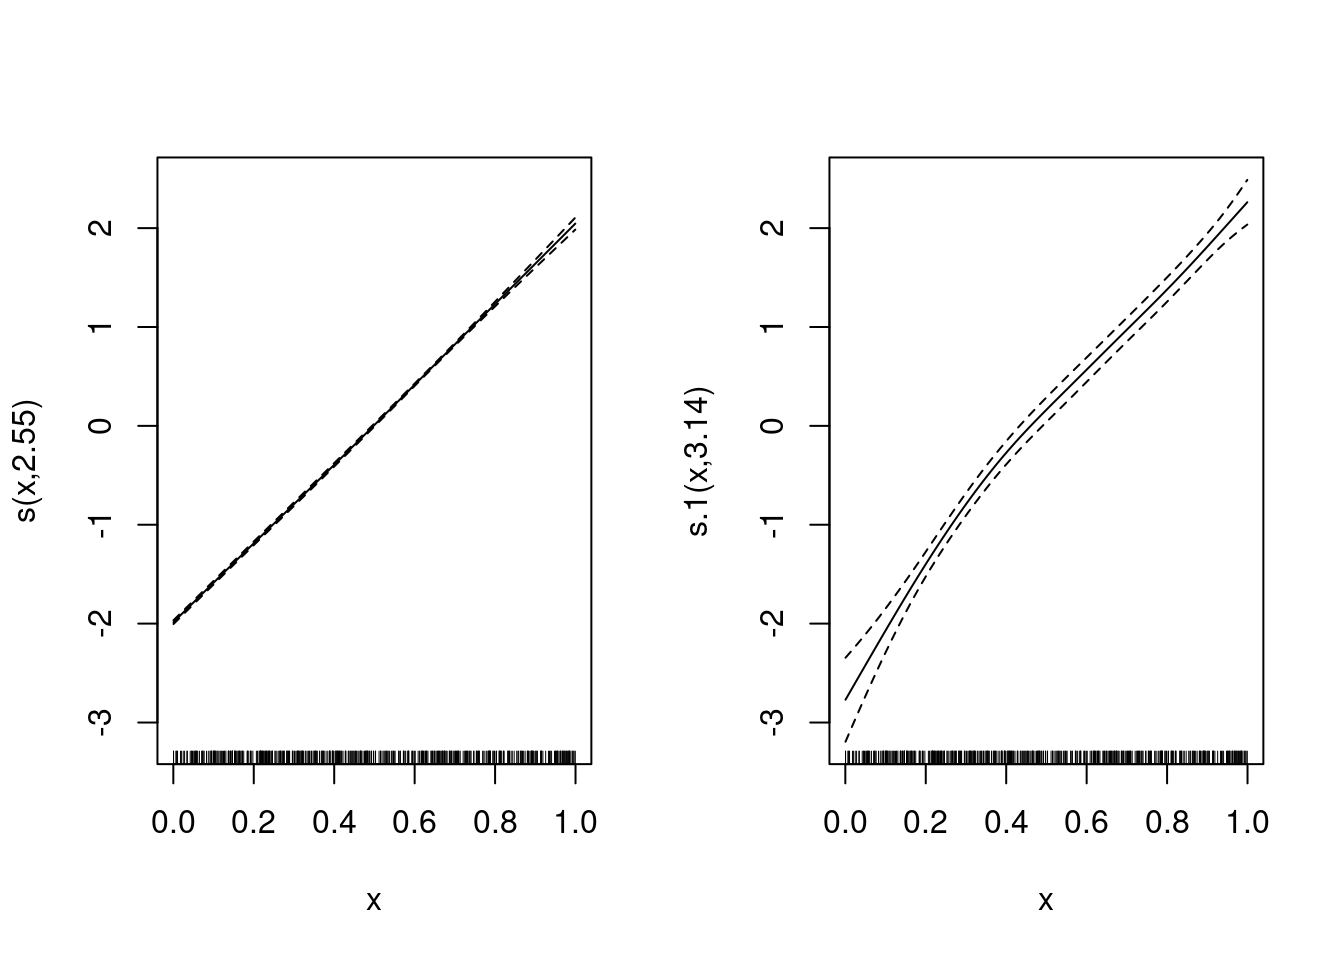

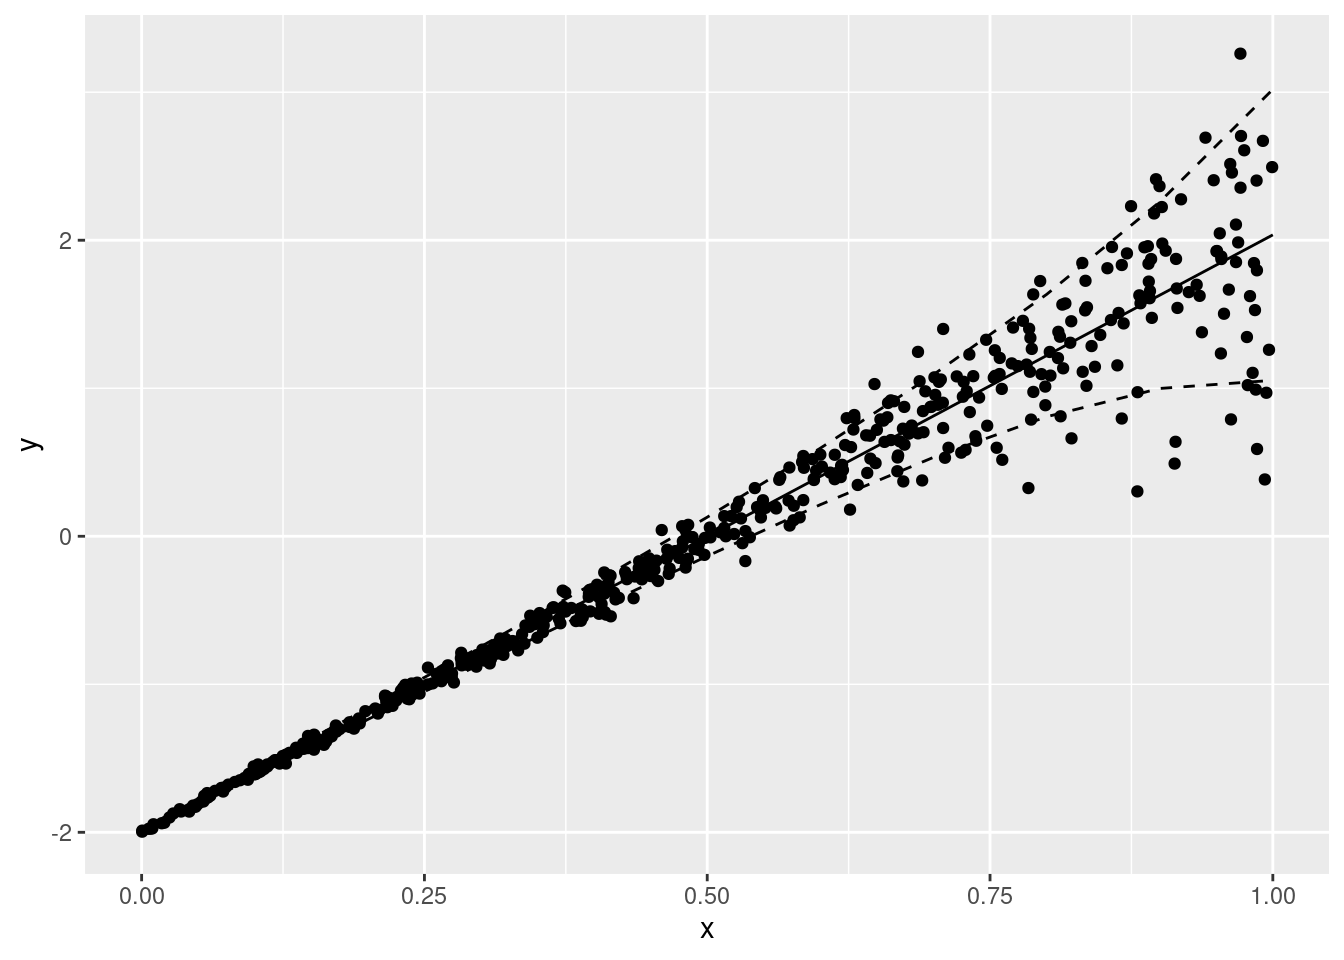

In [ ]:
n <- 500
set.seed(123)
df <- data.frame(x = runif(n))
df$y <- rnorm(n = n, mean = x, sd = .1 * exp(x))
ggplot(data = df, aes(x = x, y = y)) + 
  geom_point()

### `ziplss`

`?ziplss`

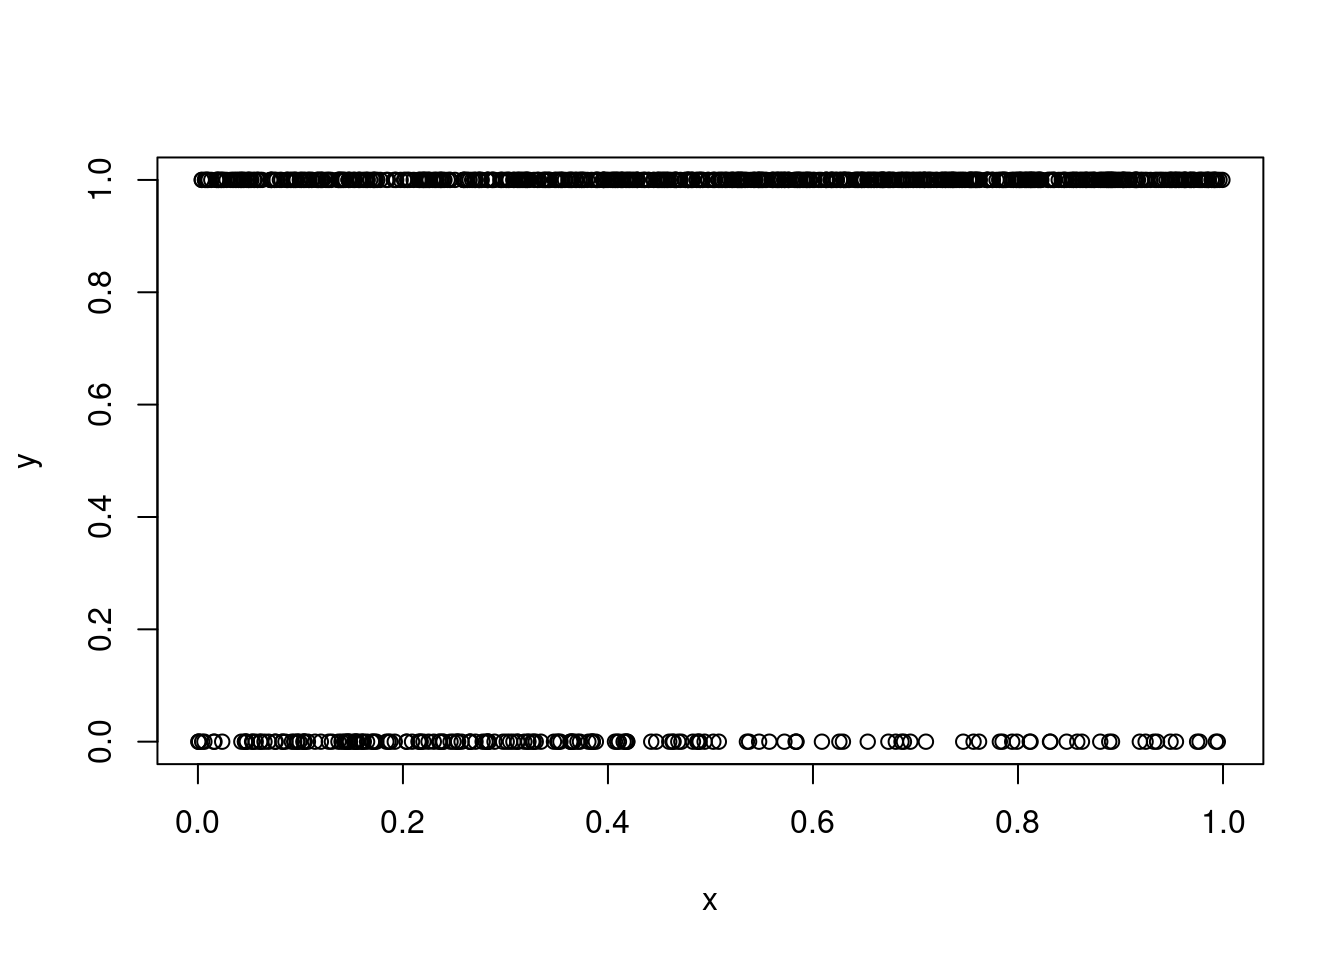

y
  0   1 
191 809 


  1   2   3   4   5   6   7   8   9  10  11  12  14 
170 167 149 106  62  54  39  21  17  14   6   1   3 

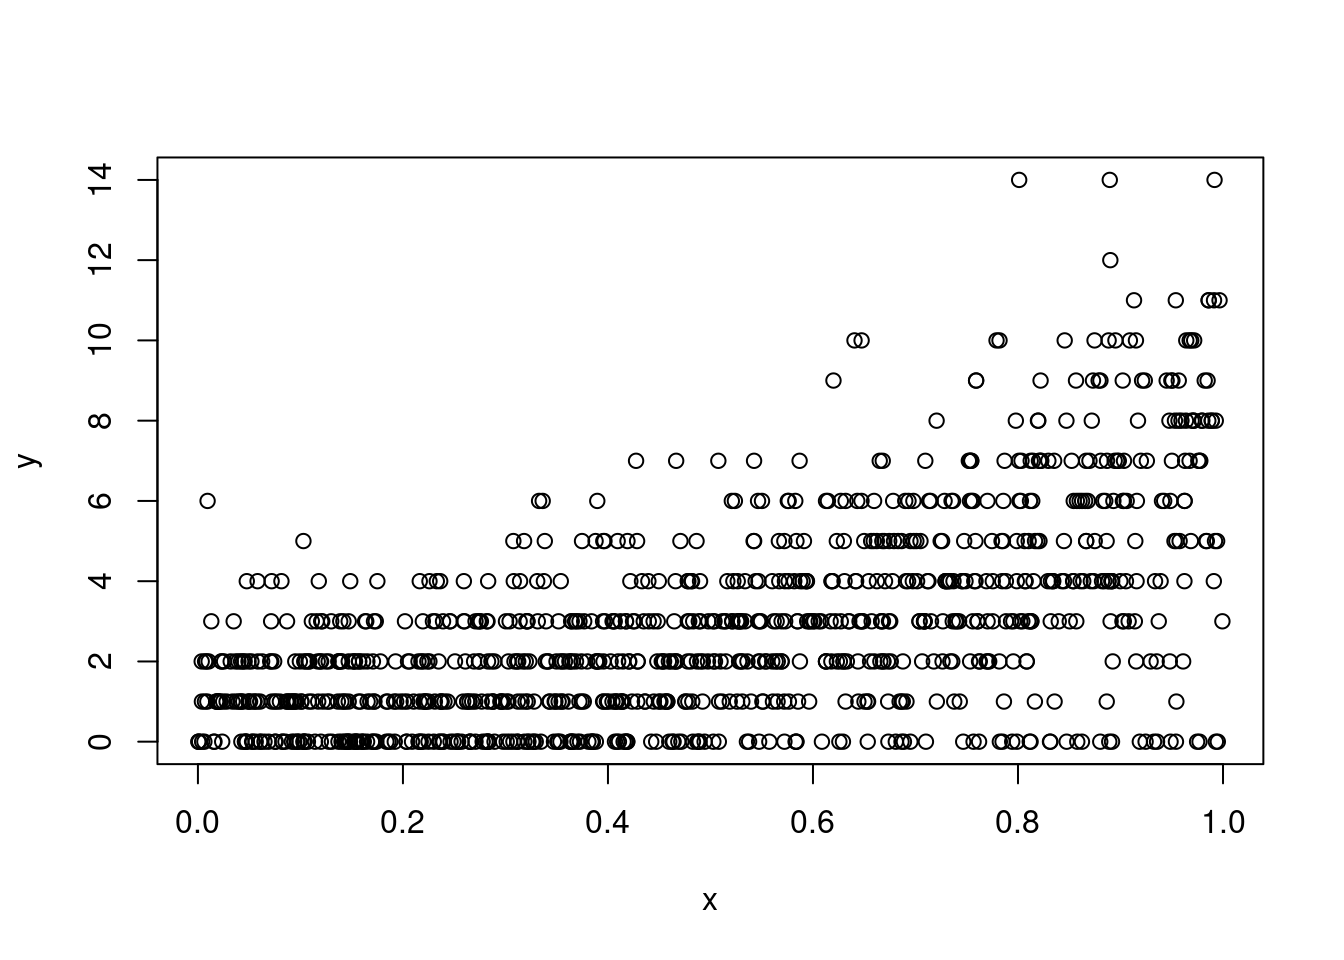

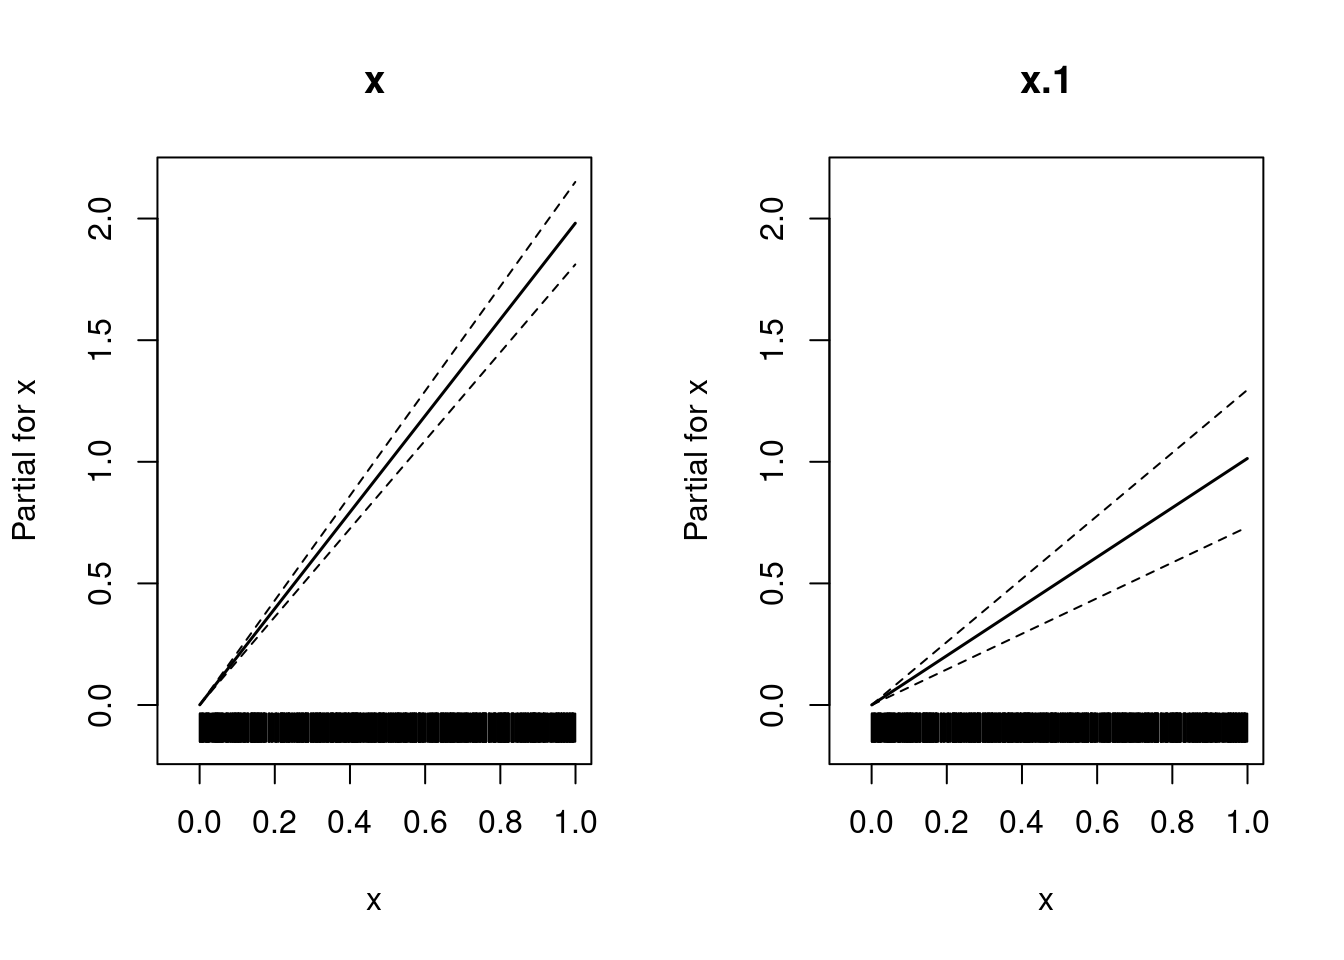

In [ ]:
set.seed(123)
n <- 1000
x <- runif(n)
eta1 <- x
eta2 <- 2*x
p <- 1 - exp(-exp(eta1)) ## cloglog link
y <- as.numeric(runif(n)<p) ## 1 for presence, 0 for absence
plot(x, y)

# References

Allaire, J. J., Teague, C., Scheidegger, C., Xie, Y., & Dervieux, C. (2024). *Quarto (Version 1.4.553)*. <https://doi.org/10.5281/zenodo.5960048>

Bürkner, P.-C. (2017). Brms: An R Package for Bayesian Multilevel Models Using Stan. *Journal of Statistical Software*, *80*, 1–28. <https://doi.org/10.18637/jss.v080.i01>

Bürkner, P.-C. (2018). Advanced Bayesian Multilevel Modeling with the R Package brms. *The R Journal*, *10*(1), 395–411.

Carpenter, B., Gelman, A., Hoffman, M. D., Lee, D., Goodrich, B., Betancourt, M., Brubaker, M., Guo, J., Li, P., & Riddell, A. (2017). Stan: A Probabilistic Programming Language. *Journal of Statistical Software*, *76*, 1–32. <https://doi.org/10.18637/jss.v076.i01>

Gelman, A., & Su, Y.-S. (2024). *Arm: Data analysis using regression and multilevel/hierarchical models*. <https://CRAN.R-project.org/package=arm>

R Core Team. (2024). *R: A Language and Environment for Statistical Computing (Version 4.4.1)*. R Foundation for Statistical Computing.

Wickham, H. (2016). *ggplot2: Elegant graphics for data analysis*. Springer-Verlag New York. <https://ggplot2.tidyverse.org>